In [1]:

import random
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import xml.etree.ElementTree as ET
import csv


def get_labels_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict


def get_features_labels(root, labels_dict):
    corpus = [] # each row is a string formed from all messages in a conversations
    labels = [] # each row is 0 or 1, corresponds to label for same row in corpus

    for conversation in root:
        string = " "
        for message in conversation:
            text = message.find('text').text
            if text is not None:
                string = string + "\r\n" + text 
        corpus.append(string)
        labels.append(int(labels_dict[conversation.get('id')]))
    return corpus, labels


In [3]:
train_data_path = '../../data/svm_training_data/'
training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()

test_data_path = '../../data/svm_test_data/'
test_data_src = '../../data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_src + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()

train_corpus, train_labels = get_features_labels(train_root, get_labels_dict(train_data_path))
test_corpus, test_labels = get_features_labels(test_root, get_labels_dict(test_data_path))

train_corpus_norm = []
train_corpus_susp = []
train_labels_norm = []
train_labels_susp = []
for index in range(len(train_corpus)):
    if train_labels[index] == 1:
        train_corpus_susp.append(train_corpus[index])
        train_labels_susp.append(train_labels[index])
    else:
        train_corpus_norm.append(train_corpus[index])
        train_labels_norm.append(train_labels[index])

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MaxAbsScaler
import scipy
# from sklearn.model_selection import train_test_split
import numpy as np

print('TODO: PLEASE REMOVE LIMITATION OF FIRST 1000 TEST CASES DONE DUE TO MEMORY ISSUES')

vectorizer = TfidfVectorizer()
_ = vectorizer.fit_transform(train_corpus)
X_train_all_unshuffled = vectorizer.transform(train_corpus)
X_train_norm = vectorizer.transform(train_corpus_norm)
X_train_susp = vectorizer.transform(train_corpus_susp)
# limiting to 1000 test cases due to memory issues
X_test = vectorizer.transform(test_corpus[:1000])

X_train_all_unshuffled = scipy.sparse.csr_matrix(X_train_all_unshuffled, dtype=np.float32)
y_train_all_unshuffled = np.array(train_labels)
X_train_norm = scipy.sparse.csr_matrix(X_train_norm, dtype=np.float32)
y_train_norm = np.array(train_labels_norm)
X_train_susp = scipy.sparse.csr_matrix(X_train_susp, dtype=np.float32)
y_train_susp = np.array(train_labels_susp)
X_test = scipy.sparse.csr_matrix(X_test, dtype=np.float32)
y_test = np.array(test_labels[:1000])

print(np.min(X_train_norm[:][0]))
print(np.max(X_train_norm[:][0]))
print(type(X_train_all_unshuffled))

scaler = MaxAbsScaler()
X_train_all_unshuffled = scaler.fit_transform(X_train_all_unshuffled)
X_train_norm = scaler.fit_transform(X_train_norm)
X_train_susp = scaler.fit_transform(X_train_susp)
X_test = scaler.fit_transform(X_test)
X_train_all_unshuffled.data -= 0.5
X_train_norm.data -= 0.5
X_train_susp.data -= 0.5
X_test.data -= 0.5
X_train_all_unshuffled.data *= 2
X_train_norm.data *= 2
X_train_susp.data *= 2
X_test.data *= 2

print(np.min(X_train_norm[:][0]))
print(np.max(X_train_norm[:][0]))

TODO: PLEASE REMOVE LIMITATION OF FIRST 1000 TEST CASES DONE DUE TO MEMORY ISSUES
0.0
0.44709805
<class 'scipy.sparse.csr.csr_matrix'>
-0.96498847
1.0


In [5]:
print(X_train_all_unshuffled.shape)
print(y_train_all_unshuffled.shape)

(14703, 121394)
(14703,)


In [6]:
# Shuffling the training data and its labels


index = np.arange(np.shape(X_train_all_unshuffled)[0])
print (index)
np.random.shuffle(index)
X_train_all = X_train_all_unshuffled[index, :]
y_train_all = y_train_all_unshuffled[index]

[    0     1     2 ... 14700 14701 14702]


In [7]:
print((X_train_all).shape)

(14703, 121394)


In [8]:
X_train_all = np.reshape(X_train_all, (X_train_all.shape[0], X_train_all.shape[1], -1))
print(X_train_all.shape)


(14703, 121394)


In [9]:

# Since the input data is in sparse matrix form, this function is used to convert it to sparse tensors.
def csr_to_sparsetensor(X):
    t = X.nonzero()
    a2 = []
    for i in range(len(t[0])):
        a2.append([t[0][i], t[1][i]])
    a2 = sorted(a2,key=lambda x: (x[0],x[1]))
    return tf.SparseTensorValue(a2, X.data, list(X.shape))


In [10]:
def create_placeholders():
    X = tf.placeholder(tf.float32, shape = [None, 121394, 1])
    Y = tf.placeholder(tf.float32, shape=[None, 1])
    keep_prob_conv = tf.placeholder(tf.float32)
    keep_prob_FC = tf.placeholder(tf.float32)
    return X,Y, keep_prob_conv, keep_prob_FC


In [11]:
def initialize_parameters(beta = 0.0):

    #Regularization
    if beta!=0:
        regularizer = tf.contrib.layers.l2_regularizer(scale=beta)
    else: regularizer=None

    W1 = tf.get_variable("W1", [16, 1, 8], regularizer=regularizer,
                         initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [8, 8, 16], regularizer=regularizer,
                         initializer=tf.contrib.layers.xavier_initializer())

    parameters = {"W1": W1, "W2": W2}

    return parameters, regularizer

In [12]:
def forward_propagation(X, parameters, keep_prob_conv, keep_prob_FC, type = "train", regularizer = None, visualizeMode = False):
    W1 = parameters['W1']
    W2 = parameters['W2']

    if visualizeMode:
        return W1
   # X = tf.sparse.to_dense(x, default_value=0)
    
#     with tf.Session() as sess2:
#         print(sess2.run(X))
#         print(sess2.run(X.shape))
    
#     s = tf.shape(X)
#     print(s)
#     X = tf.reshape(X, )
    Z1 = tf.nn.conv1d(X, W1, stride=4, padding='SAME', name="Z1")
    #print("Successfully finished first convolution")
    print("Z1 shape", Z1.shape)
    A1 = tf.nn.relu(Z1, name="A1")
    D1 = tf.nn.dropout(A1, keep_prob=keep_prob_conv)

    P1 = tf.layers.max_pooling1d(D1, pool_size = 4, strides=4, padding='SAME', name="P1")
    print("P1 Shape: ", P1.shape)
    Z2 = tf.nn.conv1d(P1, W2, stride=2, padding='SAME', name="Z2")
    print("Successfully finished second convolution")
    
    
    print("Z2 shape",Z2.shape)
    A2 = tf.nn.relu(Z2, name="A2")
    D2 = tf.nn.dropout(A2, keep_prob=keep_prob_conv)

    P2 = tf.layers.max_pooling1d(D2, pool_size = 4, strides=4, padding='SAME', name="P2")
    print("P2 Shape:", P2.shape)
    print("Successfully finished second pooling")
    
    P2 = tf.contrib.layers.flatten(P2)
    print(P2.shape)
    print("P2 Shape after flattening:" , P2.shape)
    D2 = tf.nn.dropout(P2, keep_prob=keep_prob_FC)
    Z4 = tf.contrib.layers.fully_connected(D2, 25, normalizer_fn=tf.contrib.layers.batch_norm, weights_regularizer = regularizer)

    print("Z4 shape: ", Z4.shape)

    D3 = tf.nn.dropout(Z4, keep_prob=keep_prob_FC)

    Z5 = tf.contrib.layers.fully_connected(D3, 1, weights_regularizer = regularizer, activation_fn=None, normalizer_fn=tf.contrib.layers.batch_norm)
    print("Z5 Shape : ", Z5.shape)

    return Z5






In [13]:
def find_cost(Z5, Y, regularizer=None):
    print(Z5.shape, Y.shape)

    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=Z5, labels=Y)
    print (cross_entropy)
    cost = tf.reduce_mean(cross_entropy,name = "cost")

    if regularizer is not None:
        reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)
    else:
        reg_term = 0

    cost += reg_term

    print(cost)
    return cost


In [14]:
def random_mini_batches(X, Y, mini_batch_size=32):
    
    
    m = X.shape[0]  # number of training examples
    mini_batches = []
    #X = np.reshape(X, (X.shape[0], X.shape[1], -1))

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(m / mini_batch_size)  # number of mini batches of size mini_batch_size in partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size: k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size: k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size: m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size: m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [21]:
def model(X_t, Y_t, X_test, Y_test, learning_rate = 0.009, num_epochs = 11, minibatch_size = 16, keep_prob_conv = 1, keep_prob_fc = 0.7, mode = "train"):
    tf.reset_default_graph()
    
    costs = list()
    # Here keep_prob is a float value, while kp is its tensor
    X, Y, kp_conv, kp_fc = create_placeholders()
    m = X_t.shape[0]
    print(tf.shape(X))
    parameters,regularizer = initialize_parameters()
    Z5 = forward_propagation(X, parameters, kp_conv, kp_fc, regularizer=regularizer)
    cost = find_cost(Z5, Y, regularizer)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    costs = list()
    epoch_list = list()
    if mode == "train":
        with tf.Session() as sess:
            sess.run(init)
#             temporary_test = tf.sparse.to_dense(X, default_value=0)
#             print(sess.run(temporary_test))
            saver = tf.train.Saver()
            for epoch in range(num_epochs):

                minibatch_cost = 0.
                num_minibatches = int(m / minibatch_size)  # number of minibatches of size minibatch_size in the train set
                
                minibatches = random_mini_batches(X_t, Y_t, minibatch_size)

                for minibatch in minibatches:
                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch
                    # Converts X from Sparse Matrix to Dense Matrix and then creates minibatches
                    minibatch_X = scipy.sparse.csr_matrix.todense(minibatch_X)
                    minibatch_X = minibatch_X[:, :, np.newaxis]
                    minibatch_Y = minibatch_Y[:,np.newaxis]
                    #print(minibatch_Y.shape)
                    _, temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, kp_conv: keep_prob_conv, kp_fc:keep_prob_fc})

                    minibatch_cost += temp_cost / num_minibatches
                    
                epoch_list.append(epoch)
                #costs.append(minibatch_cost)
                # Print the cost every 5 epochs
                if epoch % 5 == 0:
                    print("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                if epoch % 1 == 0:
                    costs.append(minibatch_cost)

            print("Finished Training")
            saver.save(sess, './my_model')
            #print("Cost: ", sess.run(cost, feed_dict={X: X_t, Y: Y_t,kp: 1.0}))
            plt.plot(epoch_list, costs)
            plt.xlabel("Epochs")
            plt.ylabel("Costs")
            plt.show()
            
            
    prepredictions = list()
    
    if mode == "test":
        
        num_minibatches = int(m / minibatch_size)
        with tf.Session() as sess:
            saver = tf.train.Saver()
            saver.restore(sess, './my_model')
            minibatches = random_mini_batches(X_test, Y_test, minibatch_size)
            #sess.run(init)
            minibatch_cost = 0.
            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # Converts X from Sparse Matrix to Dense Matrix and then creates minibatches
                minibatch_X = scipy.sparse.csr_matrix.todense(minibatch_X)
                minibatch_X = minibatch_X[:, :, np.newaxis]
                minibatch_Y = minibatch_Y[:,np.newaxis]
                #print(minibatch_Y.shape)
                #_, temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, kp_conv: keep_prob_conv, kp_fc:keep_prob_fc})

                #minibatch_cost += temp_cost / num_minibatches

                prepredictions.append((minibatch_Y, sigmoid(sess.run(Z5, feed_dict={X: minibatch_X, Y: minibatch_Y, kp_conv: 1, kp_fc:1}))))
    if mode == "visualize":
        sess = tf.Session()
#         with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, './my_model')
#         ret = sess.run(parameters['W1'])
#         print(ret)
        return sess, parameters    
    
    return parameters, prepredictions


In [17]:

#def model(X_t, Y_t, X_test, Y_test, learning_rate = 0.09, num_epochs = 1, minibatch_size = 16, keep_prob_conv = 1, keep_prob_fc = 0.7, mode = "train"):
    
#             num_minibatches = int(m / minibatch_size)
#             prepredictions = sess.run(Z5,
#                                       feed_dict={X: X_t[0:minibatch_size, :, :, :],
#                                                  Y: Y_t[0: minibatch_size, :],
#                                                  kp_conv: 1, kp_fc: 1})
#             for i in range(1,num_minibatches):
#                 prepredictions = np.append(prepredictions, sess.run(Z5, feed_dict={
#                     X: X_t[i * minibatch_size: i * minibatch_size + minibatch_size, :, :, :],
#                     Y: Y_t[i * minibatch_size: i * minibatch_size + minibatch_size, :], kp_conv: 1, kp_fc:1}), axis = 0)

#             if m % minibatch_size != 0:
#                 prepredictions = np.append(prepredictions, sess.run(Z5, feed_dict={
#                     X: X_t[num_minibatches * minibatch_size: m, :, :, :],
#                     Y: Y_t[num_minibatches * minibatch_size: m, :], kp_conv: 1, kp_fc:1}), axis=0)



#             predicted_result = np.argmax(prepredictions,1)
#             m = X_t.shape[0]

#             random_result = np.reshape(np.random.randint(2, size = m), (m, 1))


#             TP = np.sum(np.asarray([1 for i in range(m) if predicted_result[i]==1 and Y_t[i]==1]))
#             TN = np.sum(np.asarray([1 for i in range(m) if predicted_result[i]==0 and Y_t[i]==1]))
#             FP = np.sum(np.asarray([1 for i in range(m) if predicted_result[i]==1 and Y_t[i]==1]))
#             FN = np.sum(np.asarray([1 for i in range(m) if predicted_result[i]==0 and Y_t[i]==1]))
#             print(TP, TN, FP, FN)
#             balance_accuracy = (1/2) * (((TP)/(TP+FN))+((TN)/(TN+FP)))

#             print("Balance Accuracy = ", balance_accuracy)

#             ##TESTING THE TESTING SET


#             m = X_test.shape[0]
#             num_minibatches = int(m / minibatch_size)
#             prepredictions_test = sess.run(Z5,
#                                       feed_dict={X: X_test[0:minibatch_size, :, :, :],
#                                                  Y: Y_test[0: minibatch_size, :],
#                                                  kp_conv: 1, kp_fc: 1})
#             for i in range(1, num_minibatches):
#                 prepredictions_test = np.append(prepredictions_test, sess.run(Z5, feed_dict={
#                     X: X_test[i * minibatch_size: i * minibatch_size + minibatch_size, :, :],
#                     Y: Y_test[i * minibatch_size: i * minibatch_size + minibatch_size], kp_conv: 1, kp_fc: 1}), axis=0)

#             if m % minibatch_size != 0:
#                 prepredictions_test = np.append(prepredictions_test, sess.run(Z5, feed_dict={
#                     X: X_test[num_minibatches * minibatch_size: m, :, :],
#                     Y: Y_test[num_minibatches * minibatch_size: m], kp_conv: 1, kp_fc: 1}), axis=0)

#             predicted_result_test = np.argmax(prepredictions_test, 1)


#             random_result = np.reshape(np.random.randint(2, size=m), (m, 1))


#             TP_test = np.sum(np.asarray([1 for i in range(m) if predicted_result_test[i] == 1 and Y_test[i] == 1]))
#             TN_test = np.sum(np.asarray([1 for i in range(m) if predicted_result_test[i] == 0 and Y_test[i] == 1]))
#             FP_test = np.sum(np.asarray([1 for i in range(m) if predicted_result_test[i] == 1 and Y_test[i] == 1]))
#             FN_test = np.sum(np.asarray([1 for i in range(m) if predicted_result_test[i] == 0 and Y_test[i] == 1]))
#             print(TP_test, TN_test, FP_test, FN_test)
#             balance_accuracy_test = (1 / 2) * (((TP_test) / (TP_test + FN_test)) + ((TN_test) / (TN_test + FP_test)))

#             print("Balance Accuracy_test = ", balance_accuracy_test)



Tensor("Shape:0", shape=(3,), dtype=int32)
Z1 shape (?, 30349, 8)
P1 Shape:  (?, 7588, 8)
Successfully finished second convolution
Z2 shape (?, 3794, 16)
P2 Shape: (?, 949, 16)
Successfully finished second pooling
(?, 15184)
P2 Shape after flattening: (?, 15184)
Z4 shape:  (?, 25)
Z5 Shape :  (?, 1)
(?, 1) (?, 1)
Tensor("logistic_loss:0", shape=(?, 1), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Cost after epoch 0: 0.212759
Cost after epoch 5: 0.109621
Cost after epoch 10: 0.107392
Finished Training


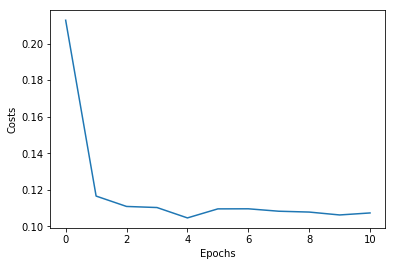

{'W1': <tf.Variable 'W1:0' shape=(16, 1, 8) dtype=float32_ref>, 'W2': <tf.Variable 'W2:0' shape=(8, 8, 16) dtype=float32_ref>}


In [78]:
parameters, prepredictions = model(X_train_all, y_train_all, X_test, y_test)
print(parameters)

In [90]:
# Testing Model

_, prepredictions = model(X_train_all, y_train_all, X_test, y_test,  mode = "test")

Tensor("Shape:0", shape=(3,), dtype=int32)
Z1 shape (?, 30349, 8)
P1 Shape:  (?, 7588, 8)
Successfully finished second convolution
Z2 shape (?, 3794, 16)
P2 Shape: (?, 949, 16)
Successfully finished second pooling
(?, 15184)
P2 Shape after flattening: (?, 15184)
Z4 shape:  (?, 25)
Z5 Shape :  (?, 1)
(?, 1) (?, 1)
Tensor("logistic_loss:0", shape=(?, 1), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from ./my_model


In [91]:
print(prepredictions)

[(array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]]), array([[0.02234191],
       [0.33782881],
       [0.02773527],
       [0.03594635],
       [0.02656033],
       [0.05790543],
       [0.02595134],
       [0.06026016],
       [0.07134534],
       [0.02298567],
       [0.05565762],
       [0.03254948],
       [0.0106489 ],
       [0.02835509],
       [0.03921336],
       [0.0035162 ]], dtype=float32)), (array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]]), array([[0.02661193],
       [0.02668813],
       [0.02689407],
       [0.02872956],
       [0.02784439],
       [0.0271851 ],
       [0.02419686],
       [0.02839424],
       [0.02751993],
       [0.62774426],
       [0.02809849],
       [0.02557663],
   

In [92]:
total = 0
misclassified = 0
for pair in prepredictions:
    
    label = pair[0]
    total += label.shape[0]
    pred = np.round(pair[1])
    misclassified += np.sum(np.absolute(pred - label))
    
print(1- misclassified/total)

0.986


In [61]:
sess, parameters = model(X_train_all, y_train_all, X_test, y_test, mode="visualize")
ret = sess.run(parameters['W1'])
print(ret.shape)
vocab_dict = {}
tot_len = X_train_all.shape[1]
print(X_train_susp.shape[0])
row_cnt = 0
summed_csr = X_train_susp.sum(axis=0)
print(summed_csr.shape)
# for row in range(X_train_susp.shape[0]):
# #     print(row.to_dense())
# #     break
#     row_cnt += 1
for i in range(ret.shape[-1]):
    ind = 0
    vec = ret[:,:,i]
#         print(vec)
    while ind + len(vec) <= tot_len:
        for j in range(len(vec)):
            if ind + j not in vocab_dict:
                vocab_dict[ind + j] = vec[j] * summed_csr[0, ind+j]
            else:
                vocab_dict[ind + j] += vec[j] * summed_csr[0, ind+j]
        ind += 2
    print("{} done".format(i))
print(len(vocab_dict))
# for key in new_dict:
#     print(vectorizer.get_feature_names()[key])

Tensor("Shape:0", shape=(3,), dtype=int32)
Z1 shape (?, 30349, 8)
P1 Shape:  (?, 7588, 8)
Successfully finished second convolution
Z2 shape (?, 3794, 16)
P2 Shape: (?, 949, 16)
Successfully finished second pooling
(?, 15184)
P2 Shape after flattening: (?, 15184)
Z4 shape:  (?, 25)
Z5 Shape :  (?, 1)
(?, 1) (?, 1)
Tensor("logistic_loss:0", shape=(?, 1), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from ./my_model
(16, 1, 8)
901
(1, 121394)
0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
121394


In [65]:
import heapq
import operator
n=100
# for key, item in vocab_dict.items():
#     print(item)
new_dict = heapq.nlargest(n, vocab_dict.items(), key=operator.itemgetter(1))
# print(new_dict)
new_list = [i[0] for i in new_dict]
print(new_list)
for i in new_dict:
    print(vectorizer.get_feature_names()[i[0]])


[53984, 94894, 119332, 76323, 75192, 84728, 28487, 101858, 66026, 51492, 51518, 55440, 107856, 101143, 93774, 43509, 99836, 2188, 61344, 100275, 30546, 73266, 34069, 37033, 77958, 23724, 79932, 27340, 46179, 17324, 118920, 31274, 100496, 64874, 96756, 41750, 111377, 100438, 114434, 107972, 102928, 8120, 68867, 103098, 84520, 77726, 49480, 7484, 43784, 111746, 94276, 103440, 106670, 45642, 36461, 96632, 69564, 61305, 80776, 79005, 92528, 94954, 106640, 105018, 62566, 63048, 48440, 99362, 65884, 45804, 84336, 16356, 33378, 81369, 81662, 101079, 85402, 82284, 20538, 43030, 46802, 79985, 3982, 43304, 82540, 69842, 49633, 15580, 91770, 53152, 47298, 84680, 85598, 46386, 37800, 96725, 15454, 103528, 39046, 34194]
hoping
secret
younger
nooo
neways
power
cloths
struck
living
handsome
hangout
iam
town
stayin
sarahs
fav
speak
1230
july
sposed
control
musta
def
dogs
ofcourse
breakfast
otherwise
chest
freeway
arbor
yelled
coz
squirt
lest
shouldnt
evening
ure
square
watched
trade
suposed
48
masturb

In [42]:
names = vectorizer.get_feature_names()
for n in names:
    print(n)

00
000
0000
00000
000000
0000000
00000000
000000000000
00000000000000000000000000000000000
000000000000000000000000000000000001
00000000000000000000000000000000001
00000000000000001
000000000000000015
0000000000d41ae7
0000000000d41aee
00000001
0000001
0000002
00000054
0000009
000000book
000001
00000119000000609
0000012
000002
000005
000006
0000063540102
000007
0000087
00001
00003633
00005
000054
000080
00009
000095399
0000c001
0000cc
0000e0
0001
000108
000110
000114
000127
0002
00020
000200
00020028
0002200c
000222
000223
00024
000243e1b1721b887575aaac37ce74b9
000269
000294
0003
000381
0004
0004005
000424
000428
000429
00044402c2e4ad4d3226c
0005
0005054fgzd
000524
00054
000574
000575
0006
0007
000715
0007152557373047
000799
0008
000892
00089484
0009
000909
000959
000969
000a
000b
000c
000d
000e
000eb
000ft
000ish
000k
000km
000rpm
000s
001
0010
001040
001066
0011
00116
001195
0012
0012f0
0013
0014
001432
001441
001475
0014a5
0015
001594
0016
0017
001783
0018
001818
001842
0019
001979
0

10years
11
110
1100
110000
11000000
110000170335
110001
1102
1102550135
110269
110325102008
11035
110385953
1104
11045
110496
11057
1106
1107551f52ede4a0957665904c8241b4
11084
11096
11097
110c
110f
110k
110lbs
110mb
110px
110sk0
110w
111
111010001010111101010110101
11102
111065
11106684817
111069
11107
1111
11110000
1111000011
11111
1111110000
11111111
11111111111oen
11116
1112
11124
11143
11145
1115
111558378
1116
11169b0f10ab
1117
1117869
111841588836169
11185
111876
111877
1118844579254
1119
11191
11192
1119570
11199
111991826926222544385
111km
111one
111oneeleve
112
11204
1121294142
1121885
1122
11225
11229
11234
112359
11239
1124
1125
1126
11262
112663
11274
11279
11294
11296
1129sec2
112cad
112cfm
112mb
112px
112s
113
1130
11301
11303
11304
11305
1131211278
113127438179392830442
1131296427
1131828648
11320
1132kb
11338
113400
11343
1134586
11347
11361
1137799947
1137954133
1138
1138169545
11384
11386
11391
11392
11393
1139454085
113995021006536704
113ms
114
1140
11402770234
11405

17000
170000
17021
17023
1703
170386
17064
17070
17071
17082031090
170cm
170euro
170meg
170px
171
1710
1711
17135
17176
17189187
171944
171db427cee236fc04af9e5de94e7c39
172
1720
1721
172103
1721249
17216
1722
1723
17239_1184808351342_1562267208_3040
1725
1725165
1727417324
172829
1729
172961898
172962750
172963374
173
1730
1730231
1731061388
1732
173259762709458
1732go
1733
1733453
173349
173355
173356
173359
173360
1734
1737
1738
17384kbps
174
1740
17434406417
174351
17439
17492
175
175193
1752
1752468267
1755
1756
175cm
175k
175lbs
175mb
176
1760
176035
17608
1762
176228
1763
1764
1765852544
1766
1769
176cm
177
1771
177166f3437b
177174381783560192
1772
1773
1774300605
17753972428972245717
17760
177777
177802
177e42a7014e
177f465fd068753b23e7e37e62c0d93b
177mhz
178
178092
17816
17838
1784
1785
1786591555
1787
178755798938319800
1789
17893
178cm
179
1790
1790727
1790883333
1791
179157
1792
1793
1794
179738
179883_172641699448532_100001081101384_381483_3935737_n
1799
179_no_change
179cm

200usd
200x
200x100
200x200
200x3ff
201
2010
20100
201000px
20100128
20100131
201002
20100203
20100222
20100225_canvas
20100304
20100311
20100323
20100402
20100417
20100423
201005
20100513
20100514
20100518
20100531
20100602
20100603
20100622
20100624
201007
20100916
20100px
20101001
20101006
20101019
20101028
20101210
20101230
2010_03_01_archive
2010_4_28
2010_rankings
2010apr
2010aprjun
2010aug
2010dec
2010feb
2010jan
2010janmar
2010jul
2010julsep
2010jun
2010mar
2010may
2010nov
2010oct
2010sep
2010www
2010â
2011
201101
20110111
20110118
20110123174457
201103
20110317
20110525
20111
20111122
20111201
20111212142243
20111219
2011apr
2011aprjun
2011aug
2011august
2011feb
2011jan
2011janmar
2011jul
2011julsep
2011jun
2011may
2011nov
2011octdec
2011sep
2012
20120320
2012feb
2012jan
2012janmar
2013
2014
2015
2016
2017
2018
2019
201px
201x
202
2020
202006
20200px
20204
202045
202063029
2020i
2021
2022
2023
2024
20244958678455
2024gb
2026
2027
2028mb
202916478
202d
202f
203
2030
20301
20318

2950
29500
295359
2958234
296
2960
2960991
2961
296107
296120
2962qt94
29638865cc2212219a29c1d1792eadef
2965
297
29727935682f55b4c65eda46e00786f1
29740
2975
29781620
2979
298
2980
29807224782917c753c1fe2a43b79fb1
29888
2989
298d
299
299009
29914
29915
29957
299ee1877a129c8dba5cdcea319c882e
29_
29a
29a5
29a9ec814634
29b72012b52db616be16207cea91edfe
29b907508e8beec9ae96654811d6646b
29c04jr
29c2qrq
29d2
29e247eef9ae
29ed5bf5b1d0
29f
29fbbbc353617fcd860dfb0132994d08
29fdytf
29k
29mpg
29n12316
29old
29s
29th
29v
29w
29x68ts
2_05
2_3_ghz
2_i386
2a
2a0113f14d3c
2a1pre
2a3da254cb49167bf82b3a66068abe61
2a753bdf022916325fe8de843e0abf48
2abe8830e12cf597d96f4a3474672d27
2abig
2ad45b420a1c
2ad7ac17dee6aea547eb096eb60df726
2af4eefbcbf6
2af6e3d6cffbd71cc44455bb8782f793
2afd7ae68e8b
2afontcolor
2afontsize
2akikvt
2am
2amish
2amrican
2aqoukg2dz0
2b
2b1
2b4ee55d7e6e635d
2b7ea250c73945b1f2c9e60223927e00
2b8303374fb3
2b8cbb4405aaf8e4700ed53266152630
2b9ba326411fcc3417b0950915e2a810
2bbdd75a560c38249a191ff

353fa4cc248867e98de9cab7d122c320
354
3543
35487dd12972
354ms
355
3550
3550s
355172
355244
3554249843
3555
3559
3560
35694
357
35770
357aa701ab27049eecb26bbb4d5b8d32
358
3584
358bath
358f05eb3e9a79b5
359
3590235902353
359074o
35989
359d3970aba4
35c
35h
35k
35kb
35kg
35mb
35minutes
35mm
35n9an6
35ppm
35pt
35ud20
35xx
35yrs
36
360
3600
36000
3603
36056
3606
3606497566
3608
36097
360w
361
3610
36115d825250ef3eb7484221d8167e7b
36120
362
3620s
3624
3626036
3628
363
363252512562
3632758166055328087
363eeaf12f855931a2ba5218a71cf5cb
364
3640
36428
364356
3646e3eecfa2
36488a9d90a65669994498f902c4dffc
365
3650
365024
3651
3654443
366
3663
3668544285
367
367207
36793
368
36835
3684946
368909
369
369030000
3695
36975
36998b421e7044b3c94d4ea2e0cdd1e0
36aag
36b
36c
36cs
36d
36dd
36dds
36f8eeda5467f5b6ef7c23d729a553a6
36g
36gb
36k
36mb
36px
36string
37
370
3700
37036456
370592
37064
3707
370ms
371
371250
371648
372
37204148751433728
37205058638585856
372161
3723
372564
37293072
3734
374
37463105637012

4c
4c202c4816405ce1463bf93605cba3f9
4c3305a5f44b1c0a170b065ee7b0c545
4c681049601b3c374f1d2c0077c99049
4c98
4ca1d7017765e54411ae8e24764d7ac1
4cac87edef4b682d8c54863d436b5df4
4cacea58
4caecb738af6
4cahn
4cbb83f99f9692df31c8fae4c989556f
4cd
4cd8374900ad
4chan
4chan4
4channer
4color
4cpus
4cvmmp
4cyl
4d
4d027150f7b41873cdaf6ced5ee1ab59
4d05dc3c4352ebe7593b536f2078cfe9
4d2a769942601baa26f55634a8eb251b
4d3d2cb5ce61
4d401e
4d647473081c3ad729446a01a377813b
4db1d4a794c6a0e217302385866a5322
4dd217ba7542bb00a127f682e2c3ad27
4de1c24ecf8e782b22dabf4e266732bb4fbddf90
4def53ff425b42855e1cf93629b04eaf
4dfbd02627921
4digit
4door
4e
4e034d79f6fd38d71ee4b49748485a3eweb
4e12
4e1bsg
4e2214da4a82
4e3733bac5d8
4e528aa62dacc1d204b6b9a06e317317
4e579248d00de44e221b0a21eb34329e
4e63bbbffbcaf12608512401eaf11240
4e67
4ed4a4323e9b8311b28d81c4d851ecbc
4ek
4ekam
4em
4erveno
4esw
4eta
4eva
4ever
4everything
4evr
4f3240ed1496
4f4ff8e2540c0867e411ec33066a9a6d
4f6020ce3b7b09ee2eac28d07ed044b1
4f6e
4f7b888020097eaa802a99

670
670087
6701
6705c6d13132
67081bb6526e
671
6710
672
67228
67234_106280702772055_100001703763600_54125_7397996_n
6724
672504
672507
67266
672944
673
6730
673017
673405
673689
6739710473912337648
674
674725
6748s
675
675015
675020
675499
676
6760
67629
677
677154
677166
677294
6774
6776a0df301145ee5837cb2c31372d21
677883
677m
678
6780
6786545678
67882
678965
678f45c7884b4a1dd45e5ca10dfac81a
679
67989
67998
67aaafa2b86d274372d74226b40f98d5
67ab482559bf3f830bdf948ab892778a
67bafbfed8bfdf46d032f1ca4fc0cfd1
67k
67px
67usd
67xx
68
680
6800
6800gs
6800le
6800xt
6801
68030
68040
6805
68060
6809
680l1833l0l1970l7l7l0l0l0l0l373l1527l2
681
6811f8ecdb76147cc7ceed5aa4fec0cc
68179
681986048
682
68222
68224
68227
682591805
682770
6829
683
683127
68366
683800000
683852
683861000
683918000
683953
68397
683985954
684
684045
6844
684402000
684b586fde4c
685
6853
68551
685585467
685847
685909
686
686909
687
687422
687702
687834
688
6880
6881
688161
68864_1556015433852_1639212215_1273936_6917673_n
6889
68

86
860
8601
8601explicitly
860951437e1593cc4b76593bee01c361
860951437e1593cc4b76593bee01dd55
86123bebfedc05009c27d1ac8f8c7411
861294
8615
861840
8624599
863
86351
864
8646
865
865ee71316b7
866
8660
866595
866821
866mb
867
8672
8672337
8675306
8675309
86776
868
8684147451a6cc3b92142c6f4b78e61c
8684147451a6cc3b92142c6f4b78e61cal
8684147451a6cc3b92142c6f4b78e61caloverlay
868gbs
868mhz
869
86b8b
86cad2950224c9494ad2ef4eeca30def
86deg
86e1633aa4
86ghz
86m
86mb
86ms
87
870
8700c
87023425f8584ab838d4216538dad957
8709
870fa8ee962d90af50c7eaed792b075a
871
8715999d628225124242cfa6750fc539
8716
871a5c51b4a748ece6483e5f77671506
872
8720b1bb098a8f70d156b9fc2028d7db
8727545
873
8732
8738
874a414b
875
875352
87557
8762
876f3aa8d5bea53881de8315f292288a
877
877773
8782ac0c77935b842ee42d72f487cef5
878994468a02
878a85276c31411e2cb8d1ca4bf8c69e
879
8798deca92af07eccdb21a777058f42e
879b42b5
87e077ba917c828dd843f714558da2f6
87f08b138eea
87v
88
880
8802
882
8824710
883
8838d5ec8a97532270c3fa876f22012c
884
88

aaaaaahhh
aaaaaahhhh
aaaaaahhhhhh
aaaaaawwwrrr
aaaaaawwwww
aaaaages
aaaaah
aaaaahhhhh
aaaaahhhhhh
aaaaaight
aaaaand
aaaaannnd
aaaaargh
aaaaawww
aaaah
aaaaha
aaaahaaaaa
aaaahhglllrrr
aaaahhh
aaaahhhh
aaaahhhhahahaahh
aaaahhhhh
aaaahhhhhh
aaaalmost
aaaalright
aaaand
aaaargh
aaaawwww
aaagh
aaah
aaaha
aaahaha
aaahahahha
aaahh
aaahhahahahahahahahahahahahahahahahaahahaha
aaahhh
aaahhhaa
aaahhhh
aaahhhhh
aaahhuuugghghhhhhh
aaaiiieeee
aaand
aaannnnddddd
aaargh
aaaw
aaawh
aaawww
aab03x
aabb
aabbcc
aabnf
aac
aac10
aac1259dfa2c6c5ead508f34e52bb990ailable
aacc
aacha
aache
aactually
aad758927f12b95b0cd1961f8dbee690
aadd
aadi
aadil
aaditya
aadsizedju1
aae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5uae5u
aaee
aafb96b2fa8806be307c4496867bad56
aaff
aafter
aag
aage
aah
aaha
aahe
aahes
aahh
aahha
aahhahaa
aahhh
aahhhaoaoahhhoa
aahhhh
aahh

aeiou
ael
aelfred
aelfred2
aelig
aelitis
aemilia
aeneon
aenews
aenglish
aeon
aeonsleuth
aep
aep_
aepx
aeqetc
aer
aerasec
aerial
aerials
aerica
aero
aerocomm
aerodynamics
aeron
aeronautical
aeroplane
aeropress
aerosace
aerospace
aerostar
aerrings
aerybet
aes
aesome
aest
aesthetic
aesthetica
aesthetical
aesthetically
aesthetics
aether
aethestically
aew
aex
af
af0ca4073ae396ae75862394b4ada2a5
af10fx
af202
af3dbf37599986db770f1b7851827890
af874d7381f9d71f45cf80696e4093ae
af8adcba23a7235da6a57206d36e53ef451fb67a
af8alvmds7cj
af_file
af_inet6
af_pre
afa
afacebook
afaic
afaics
afaict
afaik
afail
afain
afair
afaiu
afarkas
afb0216dbb5a9709eab37eaa5a4422eb
afb5cea5d4aa72019ff2a2767dd4397ae8461b9f
afbackup
afc
afc5cgk5hg499m3u0bmuabg5vdfgejad
afcose
afcourse
afd
afe
afemail
afetr
afew
aff
affair
affairs
affcted
affect
affecte
affected
affecting
affection
affects
afff
affff
afffliated
afficianados
affid
affilated
affiliate
affiliated
affiliates
affiliation
affiliations
affilitation
affilliated
aff

amat
amateur
amateurs
amatuer
amatuers
amature
amaxwidth
amaya
amaze
amazed
amazeing
amazes
amazin
amazing
amazingggg
amazingggggg
amazingly
amazng
amazon
amazon_standard_identification_number
amazonaws
amazonka
amazzzinnng
amb
ambedkar
amber
ambercombie
ambiance
ambiant
ambidextrous
ambient
ambigious
ambigiuity
ambigous
ambiguities
ambiguity
ambiguos
ambiguous
ambil
ambilight
ambilivent
ambitions
ambitious
ambivalent
ambivolence
ambp
ambulance
amc
amcik
amck
amcsik
amd
amd64
amd64_backup
amd_atitech
amd_pinmod
amdavad
amdbcg
amdd6
amdevolution
amdg
amds
ame
amedrican
amee2k
amee2k_
ameica
amek
amelia
amelie
amen
amenable
amend
amended
amending
amendment
amendments
amenu
amer
amercanism
amercans
amercian
amercom
ameri
amerians
americ
america
americaa
americaaa
americaann
americain
american
american1
americana
americano
americans
americany
americas
amerifag
amerigo
amerika
amerikan
amerrica
ames
amesging
amet
ametuers
amews
amex
amherst
ami
amiable
amic
amicable
amicably
amiccis
amicis


aqdweb
aqi
aqj
aqk
aql
aqmmrd57
aqmncmd1xt2
aqre
aqsis
aqua
aquabay
aquaetheral
aquagate
aquaintences
aqualuna
aquaman
aquantum
aquarium
aquarius
aquatic
aquatix
aquatopia
aquel
aquela
aqui
aquila
aquilo
aquinna
aquire
aquired
aquiring
aqwq
ar
ar0c8xsh
ar0x
ar15
ar5006ex
ar5212
ar5213
ar5423
ar_firedistricts
ara
arab
arabia
arabian
arabians
arabic
arabik
arabs
araby
aracaju
arada
aragorn
aragorn_guardian
araid
araknus
aralbalkan
aramaic
aramdune
arana
arandomurl
arar17
ararbic
arash
arashi
araujo
aray_merge
arbatry
arbitary
arbitay
arbiter
arbitrarily
arbitrary
arbitrary_webpage
arbitrate
arbitration
arbitraty
arbor
arborr
arbritrary
arbs
arby
arbyes
arbys
arc
arcade
arcades
arcana
arcane
arcata
arcfhitecture
arch
arch_1_1
arch_1_67491
archaeologist
archaeology
archaic
archana
archangel
archeological
archeology
archer
archery
arches
archetecture
archetypes
archetypo
archie
archimede
archipuram
architechture
architect
architected
architectural
architecturally
architecture
architecture_s

australian
australians
australias
australijczyka
australlia
austria
austriafag
austrialia
austriallia
austrian
austrlaia
aut
autarch
autcally
autenticate
autentication
autentification
auth
auth_
auth_mysql
auth_pgsql
auth_type
authauthority
authclass
authdaemond
authdeamon
authencate
authentic
authenticaed
authenticate
authenticated
authenticateduser
authenticates
authenticating
authentication
authenticator
authenticatorc
authenticatorconfig
auther
authid
authing
authmode
authname
author
author_id
author_info
authorability
authorative
authoratively
authorcasting
authored
authorial
authoriative
authoring
authorisation
authorise
authorised
authorising
authoritarian
authoritative
authorities
authority
authorization
authorize
authorized
authorized_keys
authorized_keys2
authorizedkeysfile
authorizes
authorizing
authors
authorís
authos
authpam_enabled
authpam_fallthrough
authroing
authstrs
authtype
authuserfile
autio
autism
auto
auto24
auto_away
auto_inc
auto_increment
auto_intro
auto_master

bara
barack
barackobama
barak
barandon
barb
barbara
barbarian
barbarism
barbecue
barbeque
barber
barbershop
barbie
barbies
barbieusb
barbques
barcamp
barcamps
barcelona
barcode
barcodes
bardamu
bare
barebone
barebone_amd
barebones
barefoot
barefooted
barelly
barely
barelyfitz
barendrecht
bares
barett
barf
barfed
barfin
barfing
barfly
barfoo365
barfs
barfster
bargain
bargaining
barge
bargin
barging
bari
baribas
baride
barista
bark
barked
barking
barks
barley
barly
barn
barna
barnehage
barnesandnoble
barney
barnyard
baroda
baron
baroque
barra
barrack
barracked
barracuda
barracude
barred
barrel
barrell
barrels
barren
barricade
barrier
barriere
barriers
barries
barring
barrington
barrow
barry
barryallen
barrytoo
bars
barstow
bart
bart_
bartden
bartender
barth
bartlebee
bartleby
bartman
barton
bartpe
baru
barusan
bary
barzabel
barzago
bas
basahin
basalamah
bascetball
basci
bascially
basd
basdtard
base
base10
base256
base32
base64
base64decode
base65536
base85
base_0
base_with_product
basead

bich
bichfu
bicho
bichon
bicker
bickering
bickie
bickoma
bicky
bicubic
bicurious
bicycle
bicyclist
bicyclists
bid
bid34588
bidden
bidder
bidding
bide
bideo
bidi
biding
bidir
bidirectional
bidning
bie
biebeeeeeer
bieber
bieeeee
bieeeeeeeeeeberrrrrrrrrr
bieh
bielefeld
bien
bieng
bient
bienvenu
biersch
bif
biffed
bifurcated
bifurcation
big
big5
big_ben_clock
big_scary_daemons
bigadmin
bigarray
bigass
bigay
bigbang
bigbuckbunny
bigcanoftuna
bigco
bigdaddy_
bigdickdrew
bige
bigendian
bigener
biger
bigesh
bigest
bigfoot
bigg
bigge
biggee
bigger
biggest
biggets
biggg
biggger
bigggest
bigggg
biggie
biggr
biggy
bigint
biglobe
biglot
bigness
bignis
bigot
bigoted
bigotry
bigp
bigs
bigtext
bigthinks
bigthumbnail
bigtime
bigtits
bigtop
bigun
bigun_lappy
bigwaste
bigwig
bih
bihar
bii
biiig
biiiiig
biiiiii
biiiiiiig
biiiiiiiiiiiiiiiiiiiiiiiiiiiiiik
biiiiitch
biiiitch
biin
biit
bij
bijan
bijection
bijections
bijeenkomst
bijing
bijna
bijouterie
bike
bikeridermike
bikers
bikes
bikeshed
bikeshedded
bikes

bored
bored_link
boredbored
boredd
boreddd
boredddd
boreddddd
boredddddddd
boreder
boredf
boredo
boredom
boredum
boredxd
boreed
boreeed
boreeeed
boreing
bores
borg
borgore
bori
boriiing
borin
borinaga
boring
boring_
boringa
boringg
boringgggg
boringly
boringness
borior
boris
borish
borismus
boriss
bork
borkage
borked
borken
borking
borks
borland
born
borne
borneo
boro
borriiiinnng
borring
borrow
borrowed
borrowing
borrows
bort
borth
bos
bosdi
bose
bosie
bosko
bosnia
boson
bosphoros
bosphorus
boss
bosscastlee
bosse
bosses
bossy
bostic
boston
bostonn
bosyen
bot
bot_help
botbo
botch
botched
botdata
boterham
both
botha
bother
botherboard
botherd
bothered
botherin
bothering
bothers
bothersome
bothh
bothof
boting
botle
botmsg
botnet
botnets
boto
botom
botoy
botpark
bots
botsmack
botsnack
bott
bottem
botting
bottle
bottled
bottlee
bottleneck
bottlenecking
bottlenecks
bottles
bottleshop
bottom
bottom_container
bottomframe
bottomline
bottommost
bottoms
bottomside
bottomw
botton
botty
botz
bou
b

butre
buts
butt
buttcrack
butted
butter
butterflies
butterfly
butterfly_horse__incomplete__by_ellulah
butterflys
butters
buttery
buttfuck
butthead
butthole
butthurt
butting
buttins
buttload
buttman
buttocks
buttom
button
button1
button_ok
buttonboard
buttonimageurl
buttonit
buttonmonth
buttonname
buttons
buttonville
buttoon
buttrape
butts
buttsecks
buttsekz
buttsex
buttssecks
buttt
butttt
buttttt
butungina
butyour
butzfr
buu
buubot
buuhh
buut
buutt
buuut
buuuubaaa
buuuulshit
buwahahaha
buwhahaha
bux
buy
buy_courselisting
buy_package
buyed
buyer
buyers
buyfast
buying
buyout
buys
buz
buze
buzilla
buzy
buzz
buzzah
buzzed
buzzer
buzzfest
buzzin
buzzing
buzzkill
buzzkilthen
buzzness
buzznet
buzzword
buzzwords
buzzz
buzzzonga
buzzzz
buzzzzzzzzzzzzz
bv
bv9arm
bva
bvb
bvcd
bvcvthr95io
bvfcdf
bvfd
bvfg
bvh
bvs
bvsf
bvsr
bvsystems
bvxc
bvxf
bw
bw9nm
bwa
bwah
bwahaha
bwahahaha
bwahahahaha
bwahahahahaha
bwahahahahahaa
bwahahahahhaa
bwahahahhaa
bwahhhhhh
bwegh
bwela
bwest
bwf
bwfiller
bwickliffe
bw

cgyr4bvcgyvft5g
ch
ch06
ch06_01
ch09s07
ch10
ch11
ch3
ch3ap
ch4
ch4n
ch7
cha
cha0n1x
chaals
chaarcters
chaatting
chachacha
chache
chached
chack
chacked
chacking
chad
chada
chaecking
chafe
chaffe
chaffey
chaffraix
chage
chaged
chager
chagne
chagrined
chahiye
chain
chaina
chainable
chained
chaing
chainging
chaining
chainlen
chainload
chainloader
chainloading
chainloding
chains
chainsaw
chair
chairing
chairman
chairs
chaitat
chaitting
chak
chaka
chakie
chakie_work
chakkya
chakpak
chakra
chakra85
chaks
chal
chala
chalati
chale
chalenge
chalk
chalkboard
challange
challenge
challenged
challenges
challenging
chalta
chalu
cham
chama
chamado
chamber
chambers
chamge
chamillionaire
chamillioniare
champ
champagne
champaigne
champaine
champion
championed
champions
championship
championships
chan
chan4chan
chance
chancery
chances
chancing
chandani
chandi
chandigarh
chandler
chane
chaneel
chanel
chanell
chanells
chanels
chang
changable
changchao
changchun
changd
change
change_
change_hat
change_title

cleanups
cleanuptable
clear
clearance
clearance_position_inline_absolute
clearboth
clearcanvas
clearcase
clearclick
cleardefault
cleared
clearer
clearest
clearfix
clearify
clearing
clearleft
clearlooks
clearly
clearpage
clearpath
clearrect
clears
clearshape
clearstate
clearstroke
cleartext
cleartimeout
cleartype
clearview
clearwater
cleary
cleavage
cleaving
clecs
cleg
cleint
cleints
clemenceau
clemens
clementine
clench
clenching
clene
clener
clenly
cleo
cleopatra
cler
clericaldoom
clerk
clerks
clerly
cleudo
cleva
clevaz
cleveland
clever
cleverbot
cleverer
cleverly
cleverness
cleverpun
cleverrr
clewn
clg
cli
clib
cliboard
clic
clicable
cliche
cliched
click
clickable
clickbale
clicked
clickety
clicking
clickjack
clickjacking
clicknotes
clickonce
clicks
clickthru
clie
clieint
client
client1
client3
client_4_0_1_examples
client_4_0_2_examples
client_uuid
clientaccesspolicy
clientcoordinates
clientdeniedbyserverconfiguration
clientelle
clientheight
clientleft
clientless
clientmachine
client

comunedifiume
comunicate
comunicates
comunicating
comunication
comunicatv
comunicazione
comunist
comunity
comunnity
comuter
comviq
comü
con
conan
conatin
concact
concall
concalls
concang
concat
concat_ws
concated
concatenate
concatenated
concatenates
concatenating
concatenation
concatinate
concatinated
concatinating
concationation
concats
concatted
concave
conceal
concealed
concede
conceded
conceed
conceeded
conceited
conceivable
conceivably
conceive
conceived
concensus
concent
concentrate
concentrated
concentrates
concentrating
concentration
concentrator
concentrators
concentret
concentrste
concept
concept10
concepting
conception
concepto
concepts
conceptual
conceptualize
conceptually
concerced
concerened
concern
concerned
concernin
concerning
concerniong
concerns
concert
concerts
concessions
conchords
concidence
concider
concidered
concient
concievably
concieve
conciousness
concirns
concise
concise_oed
concisely
conciseness
conciser
conclave
conclude
concluded
concludes
concluding
co

coviti
cow
cow42
cowan
coward
cowardly
cowards
cowbell
cowbody
cowboy
cowboys
cowboyy
cowclops
cowel
cowgirl
cowgurl
cowl
cowloving
cowo
cowok
coworker
coworkers
cowpath
cowpaths
cowpocalypse
cows
cox
coy
coyier
coyote
coys
coywolf
coz
coño
cp
cp037
cp1251
cp1252
cp1256
cp2102
cp210x
cp2j2d56
cp65001
cp932
cp950
cpage
cpan
cpanel
cpas
cpax
cpbarton
cpc
cpe
cpearce
cpes
cpg
cpg148
cpgz
cpickle
cpio
cpit
cpl
cpl_import_svg_en
cpl_meshexplosion
cpls
cplusplus
cplv
cplx
cpm
cpm_
cpn
cpp
cppaccess
cppisweird
cppl
cpr
cprofile
cps
cpsc
cpst
cpt
cptn
cpu
cpu0
cpu1
cpu202
cpu_fan
cpuburn
cpucaps
cpucount
cpudan80
cpudetection
cpuflags
cpufreq
cpuid
cpuinfo
cpuintense
cpumod
cpus
cpuz
cpy
cpycop
cpython
cqb7
cqfd
cr
cr2bz5b2
cr3
cr4
cr48
cr5eate
craaaaazy
craaazeee
craaazy
crab
crabby
crabs
crack
crack_mouse
cracka
crackable
crackberries
crackberry
crackbox
crackdown
cracked
cracker
crackers
crackhead
cracki
crackin
cracking
crackk
crackkkk
crackle
crackpot
crackrock
cracks
cracksmoker
cracktas

d4ece3d5a106401a07e4bcbba4e80aa9
d4ee82d2d
d4ve_g
d5000
d5217991a5c7374b110deb03905676f7
d52387880e1ea22817a72d3759213819
d527b871fc097b317f7993bdac0d349e
d52e32f3a96a64786814ae9b5279fbe5
d53db9630dc0ff7b4d62f87f0ea9a054
d57a85905b1c
d5ab56ba2b18
d5aff563e0dc
d5b76145848ac1596d93c865298958ef
d5bc3c770
d5ceec63ef0a
d5d
d5e0b073765cd0a45ace9f843b8eaf88
d5f549c13db7f29a9f9c330876295a67
d600
d610
d620
d642fc09b
d679c5ddcc8c70e2a9ebb1748a248c98
d698698b9d0e9ec67fd476d2a7d7d8a2
d69uhb41
d6a71719d
d6a92db27bd52bcb
d6d3296db607a0c333973a5a152e0efb
d6dc
d6e292711389fc8c3d399cd640fc8a40
d6f48eb87
d6f80eb9407e77d8baedcb41895f2582
d7
d70
d70f6b0c6a71dba2bc2727b43e977d5a
d71dab82fff4
d71eda5ec07c
d72e33279865d4b557d3e62097b5410f
d72fdda633
d7304e43ecdabb4efa0636d51408ca80
d7315bedc97f962084485f36c98c48e2
d79c91d63dd8
d7a7644ea
d7abe8363b29cc53da54d6aa3fb09973
d7d12addf6e61a6a5616418be62dcaee
d7vqhzhk
d8
d800
d810
d820
d820s
d821dbe5ef2db3d805cd0f7eea0ec33f
d82591cb60e7235a0e396d1edf4638e9
d8441a460

defy
defying
deg
degantyll
degc
dege
degeneracy
degenerate
degenerating
deggre
degrad
degradation
degradative
degrade
degraded
degrades
degrading
degrasssssi
degree
degreeds
degreees
degrees
degres
degreseven
degress
degressed
deh
dehli
dehradun
deid
deil
deilvering
deine
deined
deinen
deiner
deinize
deinstall
deinstalled
deisgn
deistinction
deit
deitarion
deitel
deity
deixar
deja
dejavu
dejo
deket
dekh
dekha
dekhe
dekhni
dekho
dekhte
deko
deku
del
dela
delagation
delaney
delaware
delay
delayed
delaying
delayload
delays
delayswitch
delcare
delcorp
deleated
delect
deled
delegate
delegates
delegating
delegation
delek
deleoping
delerious
delerium_
delet
deletability
deletable
delete
delete_catalog_role
deletecontents
deleted
deleted_users_backup
deletefilew
deleteing
deleteit
deletelistitem
deleter
deletes
deleteselfonconsumerthread
deleteset_click
deletesoftware
deleteting
deleting
deletion
deletionist
deletionists
deletions
delets
deleukstefoto
delewis
delf
delfino
delgine
delhi
delhied

dilate
dilbert
dildo
dildos
dile
dilema
dilemma
dilemmas
dilemna
dilerim
diletante
diliat
dilibertly
diligence
diligent
dilivery
dill
dillema
dilligence
dillinger
dilliverd
dillo
dilma
dilman
dilout
diluted
dilutes
diluting
dilution
dim
dim_download2_e
dim_p4_9100
dimaa
dimage
dimagkharabhogyahaitohyekyakarrheho
dimana
dimananya
dimas
dime
dimencion
dimension
dimensional
dimensioning
dimensionless
dimensions
dimention
dimentional
dimentionless
dimentions
dimes
dimesions
dimi
dimi3
dimik
diminfo
diminish
diminished
diminishing
dimis
dimitri
dimitris
dimitry
dimly
dimm
dimmed
dimming
dimms
dimple
dimples
din
dina
dinami4en
dinamic
dinamically
dinaosurs
dinasours
dinasty
dinatuttar
dind
dind3r87
dinda
dindinx
dindt
dine
dinenr
diner
dinero
dinf
dinfo
ding
dingading
dingaling
dingb
dingbat
dingen
dingo
dingy
dinin
dining
dink
dinking
dinkleberg
dinky
dinner
dinners
dinnertime
dinnr
dino
dinodday
dinos
dinosaur
dinosaurs
dinosaurus
dinosour
dinotastic
dinput
dinput8
dinr
dinsny
dinstict
din

don_inlab
dona
donald
donalds
donate
donated
donates
donateware
donating
donation
donations
donauhochwasser2002_2
donauhochwasser2002_3
donavan
donbale
dond
donde
dondeks
dondelelcaro
dondt
done
doneeeeee
doneseeking
donezo
dong
dongle
dongo
dongre
dongs
doning
donk
donkerder
donkey
donkey_kong_country_but_guess_where
donkeykongcountry
donload
donne
donner
donnie
donning
donnn
donnnt
donno
donnot
donnow
donny
donnèes
dono
donot
donottrackheader
donovant
donr
dons
dont
dontbugme
dontbuild
dontcall
dontcare
dontcha
dontchaknow
dontcompilehugemethods
dontdelete
dontdisconnect
dontenum
dontlove
dontluv
dontn
dontprint
dontr
dontswallowbom
dontt
dontttt
dontu
dontvalidate
dontwanta
donu
donubt
donut
donuts
donw
donwlaod
donwload
donwloading
donät
doné
doo
doobybrain
dood
doodah
doodh
doodie
doodland
doodle
doodles
doodling
doodoo
doods
doof
doofy
dooga
doogie
dooglus
doogy
doohickey
dooin
dooing
doojin
doolin
doollars
dools
doom
doom3
doom9
doomed
doomsday
doomworld
doon
doonga
doont
dooo
d

eden
ederim
edf
edg
edgan
edgar
edge
edgecase
edged
edgeloop
edgeloops
edges
edgesline
edgesuite
edgy
edh
edhitha
edi
edible
edid
ediehow
edification
ediitng
edijus
edim
edin
edinburgh
edinc
ediom
ediot
edirectory
edison
edit
editable
editaccount
editbugs
editcommands
edited
editer
editin
editing
editingfinished
edition
edition_w0qqitemz7244213683qqihz015qqcategoryz4619qqsspagenamezwd1vqqrdz1qqcmdzviewitem
editions
editline
editmode
editobject
editor
editoral
editorial
editorialize
editorially
editorjsfile
editors
editorship
editpad
editplus
editprop
editrole
editror
edits
edittextchanged
editthis
editting
editusers
edlin
edmonton
edmorally
edmorley
edmundo_v
edn
edna
ednata
edno
edo
edpno
edps
edpsweb
edqf
edridge
edrin
eds
eds2
edskes
edt
edtards
edtqfczoz9vvaca
edu
eduardo
edubintu
edubuntu
educade
educate
educated
educating
education
educational
educators
educatuon
educauded
educause
eduction
edudomain
eduflex
edugonch
edumb
edutf
edward
edward123
edward_tls
edwardoconnor
edwards
e

errorcontrol
errord
errordeveloper
errordocument
errored
errorerror
errorevent
errorfile
errorhandler
erroring
errorinserting
errorless
errorlog
errormesage
errormessage
errormessages
errorneous
erroro
errors
errorsa
erros
errot
errpt
errr
errrm
errrmm
errrmmmm
errror
errrr
errrrm
errrrr
errrrrrr
errrrrrrniiii
errrrrrrrrrrrr
errs
errthang
errtheblog
errupts
erry
ers
ersgse
ersin
erson
ersonally
erst
erste
ert
ertg
eruby
erudified
erupt
eruption
erupts
erv
ervtyuhing
erw
erwan_taf
erwin
erwtrrwet
erxz
ery
erzeugen
erzo
erzzzzzzzzzzzzzzzzzzzzzzzzz
es
es0pol
es3
es4
es40
es5
es6
es_es
es_ve
esa
esaily
esapanol
esas
esaxe
esbindingissues
esc
escact
escala
escalades
escalate
escalated
escalates
escalating
escalation
escaletes
escapa
escapades
escape
escape_sequences
escaped
escapeflag
escapes
escapexml
escaping
escargots
escholarship
esci
escience
esckeys
escola
escort
escreva
escribe
escribes
escrits
escuchado
escuela
escurreque
escuseme
esd
esdv
ese
esearch
esection
eseidel
eselect
esepci

eyoeww
eyolf
eyou
eypo
eyr
eys
eyse
eyvind
eyw
eyy
eyyy
ez
ezcool
ezd
ezdo
ezevlj
ezform
ezgranny420
ezier
ezltub
ezmin
ezona
ezrafree
ezret
ezrhp
ezsetup
ezub3
ezureus
ezxvhd73
ezy
ezyang
f0
f00
f0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000k
f003a94f418bf8eeadd820910c0c8564
f00d
f00f
f00li5h
f0209e25e0b95286685db69782fac324
f023c541e0d9131d3c567a8f6a2d9bfa
f0719ea8e993ccca9ffca5334b96f546
f09b8ec0bb0fb3701e6f7f9e1e6d0708
f0da7f6aef4b2da858fa542404a400aa
f0f0451c75eb
f0r
f0wh3c8w
f1
f10
f109a63709e702ed304a85e971b0f710
f10panel
f11
f112be1869489064e247bbd0cf611518
f12
f12005finalrelic5iu
f1259a9f9150e84e5c67c9e8f44cc1d2
f139aba52f9fa1394b4034a7954b2220
f13bb1bed03db9d68a7d9a48aafeec78
f13bb1bed03db9d68a7d9a48aafeec78ally
f13bb1bed03db9d68a7d9a48aafeec78sporny
f13w
f14de8990c8b25022fed1c699ffa487a
f15
f16
f17
f17f53ee16d7
f18
f19canad
f19fe81cc92b1efcd1dd6a097ab17b05
f1hu1
f2
f2006
f20china
f21
f21china
f21us
f22
f220ec282604

fiscally
fisety
fish
fishbomb
fishbot
fishbowl
fished
fisher
fishes
fishey
fisheyes
fishhhhhhhhhhhhhh
fishhy
fishi
fishie
fishing
fishmaster
fishmonkstudios
fishsponge
fishtank
fishy
fishyy
fisicaly
fisicily
fiskars
fiskebolle
fisrt
fisshing
fissioin
fisst
fist
fistfight
fistfullast33l
fisting
fistly
fists
fit
fitch
fite
fiting
fitness
fitri
fits
fitst
fitted
fitting
fitty
fitwib2r
fiulling
fiume
fiumerapido
fiuu
fiv
five
fiven
fiver
fives
fivesome
fiveth
fix
fix_via_handler_table
fixable
fixating
fixboot
fixbrokenlink
fixd
fixdel
fixe
fixec
fixed
fixedvals
fixee
fixes
fixey
fixign
fixin
fixing
fixings
fixmbr
fixme
fixored
fixpng
fixthe
fixture
fixup
fixups
fixx
fixxed
fixxx
fixyourownprinter
fiz
fized
fizz
fizzed
fizzile
fizzle
fizzled
fizzy
fj
fjalls
fjas
fjbhiorstrujrs
fjdaskljfds
fjdjjrg
fjfjfjfjfjfjfjf
fjgi
fjgi0
fjgjfdgjdjfgjdfg
fjhg
fjiowuperwiqhjfasd
fjksa
fjords
fjt
fjvak
fk
fka
fkadsl
fkcqh2
fken
fkey
fkeys
fkhdshglsdakgd
fkin
fking
fkljgper
fkn
fkre
fksfheifnlrmvdshqwr
fkwef

frequently
frequento
frequents
freqvensy
frere
fresh
freshen
fresher
freshers_fortnight_sexy_student_holly_28__0
freshes
freshh
freshly
freshmam
freshman
freshmeat
freshmen
freshnet
freshports
freshwater
fresnel
fresnell
fresnet
fresno
fresshh
fretting
freud
freudian
freund
freunde
freunden
freundn
freware
frex
frexsh
freys
freze
frezes
frezzes
frg
frggin
frgt
fri
friccking
fricken
frickin
fricking
friction
frictionless
friday
fridaygram
fridaygram_29
fridays
friddget
fridge
fridges
fridget
frie
fried
friednly
friedrich
frieds
frieends
frieinds
frien
friend
friendid
friendless
friendlier
friendliest
friendliness
friendly
friendlybit
friends
friendsh
friendship
friendships
friendssaid
friendsssss
friendz
frieng
frienly
friennds
friens
friensd
frienship
fries
friezerb3
frig
friggen
friggin
frigging
fright
frighten
frightened
frightening
frighteningly
frightens
frigign
frih
frik
frik85
frik95
friken
friki
frikkin
frills
frilly
frim
frind
frindly
frinds
frined
frineds
frinends
fringe
frio


gebeurd
gebgn
gebi
gebid
geboren
geborne
gebregzi
gebruik
gebus
gecko
gecko_plugin_api_reference
geckoish
geckoness
geckos
geckosenator
ged
gedaan
geddy
gedit
gedmurphy
gee
geed
geee
geeeeeee
geeeeeeez
geeft
geek
geekboi
geekery
geekfinder
geekfound
geekhood
geekier
geeking
geekmeet
geekmet
geeko
geeks
geektion
geeky
geekz
geemark
geen
geenerally
geenrally
gees
geese
geetin
geez
geeze
geezzz
geforce
geforce2
geforce4
geforce6800
geforce_6_series
geforce_7_series
geforce_8_series
geforce_series
gefragt
gefunden
gegangen
gegege
gegen
gegund
gegya
geh
gehabt
gehat
gehe
gehen
gehibi
gehoord
gehst
geht
gehts
geico
geil
geje
gekkou
gekregen
gel
gelderland
geldi
geleden
geleen
gelernt
geliyo
gella
gelled
geloest
gelogen
gelp
gelukkig
gem
gemacht
gemany
gemar
gemeindeba
gemer
gemetria
gemidjy
gemini
gemma
gemrany
gems
gemstone
gemtek
gen
gen1
gen2
gen_download
gen_download2
gen_eth
genannt
genarally
genau
genaues
gende
gender
gender_symbol
gendered
genders
gendocs
gendr
gene
genedrate
geneh
ge

goblok
gobolinux
gobs
gobsmacking
goby
gocarts
gocery
goclean
god
god_virus
godaddy
godamn
godamnit
godawful
godbless
godd
goddam
goddammit
goddamn
goddamned
goddamnit
goddd
godddamn
godddddd
goddess
goddess22
goddie
goder
godess
godfather
godish
godly
godmode0
godmother
godness
godnight
godo
godocommand
godont
godparent
gods
godsai
godsend
godsname
godt
godwin
godz
godzirra
goe
goed
goede
goedemorgen
goeiemorgen
goeland86
goemon
goers
goertz
goes
goesdwn
goesup
goeth
goetzi
goez
gof
gofastgaming
gofly
goflyakite
goflyapig
gofuckyourself
gofy
gog
gog123
goggleliscious
goggleliscioushey
goggles
gogi
gogint
gogles
gogo
gogol
gogot
goguen
gohoh
gohst
goi
goibhniu
goig
goign
goiiin
goiiinggg
goijng
goikng
goin
goind
going
goingg
goinggg
goingt
goingto
goingtoprint
goinig
goinna
goinnngg
goinq
goint
goirls
goive
goja
gojackoff
gojaimath
gojanyen
gokarting
goko
goku
gokusen
gol
golbat
gold
gold12tq6
goldberg
goldcoast
golden
goldfarb
goldfish
goldshlager
goldstien
goldtradingpost
golein
gole

haiden
haieee
haifax
haight
haii
haiii
haiiiii
haiiiiiiiiiiiiiiii
haiiiiz
haijing
haiku
haikus
hail
hail_spacecake
hailee
hailey
hailing
hain
haines
haiooooooooooooo
hair
hairballs
hairbit
haircut
haircuter
hairdo
hairdresser
hairdut
haired
hairfree
hairin
hairless
hairpulling
hairr
hairry
hairs
hairslyle
hairspray
hairsrapy
hairstyle
hairstyling
hairy
hairyy
haitch
haiti
haitian
haivng
haiya
haiyaa
haiz
hajam
hajime
hajoor
hajával
hak
haka
hakala
hakc
hakdiv
hakim
hakimel
hakkon
hakon
hakowe
hakuna
hal
hala
halarious
halatio
hald
hale
halebop
halelujah
halen
haley
haleyann
half
halffontsize
halflife
halfops
halfs
halfvalue
halfway
halfwidth
halfwits
hali
hali_
halibriam
haliburton
halibut
halifax
halindrome
hall
hallais
hallarious
halle
halleluah
halleluja
halley
halliburton
halllaaa
hallllllllo
halllooooooooooooooooooooooo
hallls
hallmark
hallo
hallooo
hallow
hallowed
halloween
halloweennnnn
hallows
hallp
halls
hallucinate
hallucinated
hallucinating
hallucinogens
hallvord
hallvors
ha

hike
hikie
hikin
hiking
hikm
hilareous
hilarious
hilarity
hilarriiouuss
hilary
hilda
hildon
hile
hile_
hilfe
hilfsprogramm
hilft
hilight
hilighted
hilighting
hilights
hilink
hilited
hill
hillarious
hillarius
hillary
hillbilly
hilling
hills
hillster
hilly
hilton
hiltons
hilux
him
himachal
himalayas
himanshu
himansu
hime
himelf
himem
himen
himexcpet
himiq
himm
himmelstr_utz
himmm
himmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm
himn
himself
himym
hin
hina
hindawi
hinday
hinder
hinderence
hindering
hinders
hindersland
hindhi
hindi
hindsight
hindu
hinduism
hindus
hine
hiney
hing
hinge
hinged
hingeness
hinging
hingwah
hink
hinky
hinlin
hint
hinted
hinting
hints
hio
hioh
hioooooooo
hiow
hip
hipg
hiphop
hipo
hippicrictial
hippie
hippies
hippietrail
hippo
hippocrit
hippopotamus
hippopotamuses
hippos
hippy
hips
hipster
hipstercat
hipsters
hir
hiragino
hire
hired
hiren
hires
hiring
hirithik
hirnlos
hiro
hiroki
hiroshima
hirosima
hirse
his
his_dudnes
hish
hisovenen
hispanic
hispanics
hispano
hispanohablant

hypnotises
hypnotist
hypnotized
hypo
hypocrisy
hypocrite
hypocritical
hypotenuse
hypothermia
hypothesis
hypothesise
hypothesised
hypothesize
hypothetical
hypothetically
hypotheticals
hypothetics
hys
hyst
hyster3
hyt
hytime
hytimekimber9701
hyudai
hyundai
hyung
hyunju
hyuuuuu
hyv
hyves
hyvin
hyvs
hyvä
hyväää
hyy
hyye
hyypiä
hyyyyyyyyyyyyyyyyyyyyyy
hyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy
hz
hzhsun
hzvnoinjf
hzwoxl23
hát
hã
hä
händer
hänninen
här
hässleholm
hästar
håndball
håndtverk
hår
hæ
hééé
hêhê
högre
höhö
höra
höre
hörn
höður
høres
hú
hübsch
i00k
i070
i0h
i0h0
i0p
i0s
i1
i1008
i1082
i109
i11
i1184
i1185
i12
i1229
i126
i183
i18l
i18n
i18ndg
i18ning
i18nised
i19
i2
i20
i23
i24
i241
i248
i26
i262
i268
i281
i2c
i2c_add_adapter
i2c_del_adapter
i3
i30
i303
i304
i31
i34
i35
i356
i37
i38
i386
i386cd
i386pc
i39
i3r
i4
i40
i405lkavzw
i41
i42
i43
i44
i449
i45
i46
i47
i48
i486
i49
i4m
i5
i50
i51
i51x5
i52
i53
i54
i55
i550
i56
i586
i5os
i6
i674
i686
i69
i6ghlhbyvea
i7
i72
i739
i8042
i8042prt

indonecia
indonecial
indonesai
indonesi
indonesia
indonesian
indonesians
indonesianya
indonesie
indoor
indoors
indore
indows
indranagar
indranil
indridcold
indroduce
indroduced
induce
induced
inducing
induction
inductive
inductively
indulge
indulgence
indulging
indum
indus
industrial
industries
industry
indy
indyjt
indykit
ine
inebriation
inedness
ineed
ineens
inefective
ineffable
ineffective
ineffectual
inefficiencies
inefficiency
inefficient
inefficiently
inelegant
inend
inept
inequalities
inequality
inequities
inernet
ineroperabel
inert
inertesction
inertia
inervate
inesfale
inessential
inet
inet_pton
inet_sbc
inet_tw
inetadm
inetconv
inetd
inetinterface
inetpub
inettimepageproc
ineuroland
ineva
inevitable
inevitably
inevitaby
inex
inexcusable
inexorably
inexpensive
inexperience
inexperienced
inexperinced
inexplicable
inexplicably
inez
inf
infact
infalid
infallible
infamous
infancy
infant
infantry
infeasible
infect
infected
infection
infections
infects
infer
inference
inferior
infer

iso10646
iso2
iso2145
iso5
iso639
iso8601
iso8859
iso9660
iso_2145
iso_8601
iso_8859
iso_8859_1
iso_iec_jtc1_sg29_wg11
iso_list
isobar
isoblah
isoc
isodates
isohunt
isolate
isolated
isolating
isolation
isolationawareapixxx
isolationist
isolinux
isolis
isomorphism
ison
isopod
isopropyl
isorted
isory
isos
isosetup
isoss
isotf
isotopp
isp
ispartofhtml5
ispconfig
isplatformobject
isplugin
ispointinpath
ispreceding
isprimitive
isprivateuse
isprobablyforlayout
isps
isql
isqlplus
isquint
israeilis
israel
israeli
israelian
israil
isreal
isregion
isrootofanonymoussubtree
iss
issac
issamenode
issas
issaz
issearchproviderinstaller
isset
isshared
isshiki
issies
issit
isslustrated
issory
isss
issss
isssssss
issssssssssssssssssssssssssssssssssss
issu
issuance
issue
issue1569040
issue4
issued
issuer
issues
issuetemplate
issuing
issupported
issuse
issuses
issutime
ist
istache
istaches
istalled
istambul
istanbl
istanble
istanbul
istanceof
istances
istandardsbodything
istant
istargate_universei_has_a_go

jsyk
jszelda
jszou
jszouaway
jt
jtagtools
jtdg1ruoleldtm
jtella1
jteo
jtgfykijxf
jtidy
jtl
jtm
jtoy
jtr
jtrip
ju
ju65
juan
juanca
juast
juat
jubilate
jubilation
juce
juces
jucie
juciey
juckes
jucolt
jucy
jud
judas
judas_isariote
judas_iscariote
jude
judge
judged
judgement
judgements
judges
judgin
judging
judgment
judicial
judicious
judiciously
juding
judit
judo
judson
judt
judy
judytaa
juelich
juellamah
jug
juga
juggalo4lifesuckas
juggernorris
juggle
juggling
jugment
jugoslavia
jugs
juh
juhe
juice
juiced
juicer
juices
juicy
juicystudio
juijitso
juilet
juima
juivces
juj
jujimufu
jujitso
jujst
jujur
jujutsu
jukebox
jukeduke
jukerduke
jukie
jukka
jul
jul_27
julain
jules
julia
juliaa
juliamap
julian
juliana
julianbh
juliane
julians
julie
julien
juliet
julio
julious
jullard
jullarid
julliard
jullie
julouse
july
jumanji
jumbo
jumboframes
jumoing
jumoy
jump
jumpcut
jumped
jumper
jumpered
jumpering
jumperless
jumpers
jumpin
jumpiness
jumping
jumpinge
jumppoints
jumps
jumpserver
jumpstart
jumps

koria
korian
koriea
korimo
korkuom
korn
kornel
kornouille
korollary
kororaa
korpela
korrekt
korst3n
korter
korttia
kortzzz
korum
korundum
korz
korába
kos
kosaksoakosako
kosek
kosh
kosher
kosmonaft
kostee
kota
kotd
kotek
koti
kotnala
kototama
kotryna
kouas
koules
koumbit
kovalyov
kovecses
kow
kown
kows
koya
kozeries
kozlika
kozmico
kozminski
kp
kp1
kpanel
kparts
kph100
kpkg
kpoclsa
kpop
kpowersave
kqemu
kqueue
kqueues
kqzmhh_nojej
kr
kr0ntab
kr4zy4p3
kra
krab
krabi
kracker
kraftwerk
krai
kraju
krakow
krali
kram
krammer
krandom
krasuckas
krause
krav
krazaaaayyyy
krazy
krazykorean530
krazypenguin
krb
krb5
krb524
krb5_cc_get_principal
krb5i
krb5p
krebs
kreg_work
kreme
kretenu
krfb
krickey
kriegt
kriel
krijg
krijn
krijnh
krijnhoetmer
krinkle
kripken
kripple
kris
krishna
krishnamurti
kriskowal
krisp
krispies
krispy
krissy
krissys
krista
kristalino
kristell
kristen
kristi
kristiansand
kristiansen
kristie
kristof
kristoffer
kristofferson
kristoffersson
kristy
krita
kriterien
krivenok
krkeiojhf

libqx
libra
librari
librarian
librarians
libraries
library
librarys
libre
libreadline4
libreadline5
libreg
libreoffice
librestart
libro
libs
libsasl2
libsdl
libsec
libshell
libshout
libsigc
libska
libsm6
libssl
libstdc
libstruts1
libsvn
libswt
libswt3
libtasn1
libtheora
libtidy
libtiff
libtool
libtorrent
libutemper
libuutil
libval
libvga
libvorbis
libvpx
libwebsockets
libwnck
libwww
libx11
libx264
libxcursor1
libxext
libxext6
libxfixes3
libxft1
libxi6
libxine
libxine1
libxinel
libxinerama1
libxm
libxml
libxml2
libxml5
libxrandr2
libxrender1
libxslt
libxt
libxul
libxv
libya
libyan
libzfs
libzypp
lic
licck
lice
licence
licenced
licences
licencing
licened
liceneses
licening
licens
licensability
licensable
license
licensed
licensee
licenseed
licensefile
licenses
licensied
licensing
licensor
licewi
licik
licious
lick
lickable
lickcats
licke
licked
licker
lickign
lickin
licking
lickingg
lickinggg
licknig
lickning
licks
lickt
licky
licmgr
liconv
lics
licsens
licued
lid
liddel
lide
lidi
lidia


lululemon
lulus
luluululul
lulz
lulzz
luma
lumber
lumbercartel
lumberg
lumgwada
lumiferous
lumina
luminance
luminaries
luminerd
lumines
luminoso
lumix
lumley
lump
lumpur
lumpy
lumz
lun
luna
lunarcrisis
lunatics
lunch
lunches
lunchtime
lund
lunde
lunes
lung
lungs
lungshrimp
lunitic
lunitik
lunk
luns
luoyang
luoyu
lupa
lupdate
lupin
lupinenet
lupo
lure
luring
lurk
lurked
lurker
lurkers
lurkey
lurkin
lurking
lurks
lurt
lurv
luscious
luser
lusers
lushous
lusia
lusic
lussekatter
lussy
lust
lusted
lustful
lustfully
lustre
lusts
lusty
lustyreader
lusus
lutanho
lutego
lutheran
luthor
lutins
luton
lutonj
lutym
lutz
luule
luuuckky
luuuuuuuv
luuuuuuv
luv
luvbug
luvde
luve
luved
luves
luvs
luvved
luvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
lux
luxembourg
luxurious
luxury
luyt
luôºâ
lv
lval
lvalues
lvd3t
lveo
lvie
lving
lvk
lvl
lvm
lvm2
lvoe
lvs
lw
lwa
lwait
lwe
lwesson
lwizardl
lwjgl
lwkyawld
lwn
lworks
lwp
lwps
lws
lwts
lwx_baseu_net
lx
lxkdu6cdxli
lxlknfdkm
l

mcafee
mcali
mcallister
mcarter
mcaschool
mcb
mcbride
mcc
mccarron
mccauley
mccbaka
mccdonalds
mccloskey
mccoll
mccollins
mccr8
mcd
mcdoanlds
mcdonalds
mcdonalsd
mcdonolds
mcdonsals
mcds
mcdst
mce
mcedit
mcefee
mces
mcf
mcfa58d8
mcferrin
mcfly
mcfuck
mcgee
mcgibbon
mcgill
mcglynn
mcgoats
mcgraw
mcgregor
mcgyver
mch
mch03820
mch8yw83nddenge4ug9c9zwz3gvlmda
mchinename
mchitest
mci
mckenzie
mcknut
mckog
mclovin
mcmanus
mcmigrate
mconnect
mconnor
mcontent
mcop
mcp51
mcpan
mcpp
mcpu
mcr
mcrosoft
mcrypt
mcs
mcse
mcu
mcuch
mcuh
mcummings
mcxx
md
md0
md1
md2
md2rdfa
md3
md5
md5_base64
md5sum
md5sums
md5withrsaencryption
md_relax_table
mda
mdadm
mdamm
mdanjou
mdash
mdasv
mdb
mdb2
mdb2_fetchmode_assoc
mdb2_fetchmode_object
mdbcompact_latebind
mdc
mde
mdes9t4j
mdf
mdfedderly
mdfgn
mdfind
mdi
mdi_restoreframemenu
mdialcan
mdialpre
mdialpre2
mdialpre3
mdialsuf
mdialsuf2
mdialsuf3
mdickinson
mdiclientinfo
mdid
mdir
mdj
mdk
mdl
mdma
mdn
mdoc
mdocument
mdoes
mdoules_install
mdqoqdqw
mdr
mdraid
mdsys
m

mixture
mixup
mixuruca
mixx
mixxx
miy
miyazaki
miyia
miz
mizani
mizipzor
mizzou
miäki
mj
mj45rikni7kj
mjbf
mjcar
mje
mjelva_
mjf
mjhe
mjk
mjm
mjmwired
mjnkbng
mjodyluy
mjpeg
mjs
mjsdigital
mju
mjujuyt
mjukhuuukukuk
mjyiwgg
mk
mk0eop40
mk1
mk2
mk7sg
mk___
mka
mkactivity
mkae
mkake
mkan
mkanat
mkanya
mkat
mkay
mkayy
mkbundle
mkd
mkdeustch
mkdir
mke
mke2fs
mkeadle
mkennedy
mkey
mkfile
mkfontdir
mkfs
mkhive
mki
mkinitramfs
mkinitrd
mkisofs
mkiu
mklinux
mklivecd
mkn
mkpasswd
mkrause
mkre
mkreadme
mkrufky
mksession
mksh
mkspecs
mkspell
mksysb
mkt
mkt000125
mktemp
mkulke
mkv
mkview
mkvimrc
ml
ml6tsg
mladeji
mlae
mlasky
mlayasia
mldesigners
mlecha
mlh
mlia
mljlngfmkhknoligmkl
mlk
mlkmçsmdfkahnjuianda
mlles
mlm
mln
mlopes
mls
mlsrealestate
mlt
mlu
mlw
mlysia
mm
mm05z
mm1022
mm2
mm2000
mm88mmh
mm_jumpmenu
mma
mmaaaa
mmaammamamamaamamama
mmaigrot
mmale
mmam
mmap
mmapped
mmaybe
mmb
mmc
mmcache
mmcx
mme
mmfilm
mmh
mmhh
mmhhm
mmhm
mmhmm
mmhmmm
mmhmmmmmmmm
mmhum
mmiikkee12
mminit1
mminitializeblackho

musical
musicals
musicbrainz
musicc
musiccc
musich
musician
musicians
musiciansfriend
musicion
musicisair
musiclover
musicml
musicpd
musics
musicwise
musiic
musik
musilman
musing
musings
musique
musiz
muskegon
muslim
muslims
muso
muss
mussels
mussely
mussolini
musst
musste
mussve
must
musta
mustache
mustaches
mustachify
mustafa
mustafiz
mustang
mustange
mustangmatt
mustapha
mustard
mustardman
mustash
muster
musthavetools
musti
mustn
musts
mustve
musz
muszáj
mut
mutability
mutable
mutablemediatrack
mutabletexttrack
mutant
mutante
mutate
mutated
mutates
mutating
mutation
mutationcallback
mutationobserver
mutationobservers
mutationrecord
mutationreplacement
mutations
mutch
mute
muted
mutes
mutex
mutexautolock
mutexes
muth
mutha
muthaaaa
muthafucka
mutherfuckin
mutia
mutie
mutilate
mutilation
muting
mutiny
mutiple
mutk
mutli
mutlimedia
mutliple
mutlu
mutombo
mutt
mutter
mutters
mutton
muttox
mutual
mutually
muuaaahhhhhhhh
muuahahahaha
muucch
muuch
muuuaaahhh
muuuch
muuuuch
muuuuusic
muuuuu

newgunsetup
newham
newhere
newhttp
newhydra
newish
newisys
newjersey
newjs
newlabelname
newlayout
newless
newlevel
newline
newline_char
newlines
newlinwa
newly
newman
newmember
newmexico
newmode
newmousepos
newname
newness
newnotsyn
newobjectenvironment
neworder
nework
newp
newpage
newpartition
newpassword
newpath
newpers
newport
newports
newproject
newroot
newrules
news
news_id
news_piece
news_show
news_test
newsarticle
newsarticles
newschool
newsexyemilie
newsforge
newsgroup
newsgroups
newsid
newsite
newsitem
newsitems
newsletter
newsletters
newspaper
newspapers
newspeak
newsrc
newsroom
newstd
newsyslog
newt
newtab
newtable
newtestids
newtext
newton
newtown
newtuple
newtwitter
newuse
newuser
newvalue
newversion
neww
newwindow
newworld
newyork
newyorker
newz
newzbin
newzealand
nex
nexenta
nexentaos
nexentas
nexlei8
nexon
nexr
next
nextafter
nextblock
nextboolean
nextchild
nexted
nextel
nextell
nextgen
nextgui
nexthop
nextline
nextnewest
nextnode
nexto
nextpendingconnection
nextprotone

numbskull
numdel
numer
numeral
numerals
numerate
numercally
numeric
numerical
numerically
numericentities
numerics
numero
numerous
numist
numlock
nummer
nummy
numpad
numpad50
numpadvalue
numpty
numpy
numrows
nums
numskul
nun
nunavut
nunca
nunit
nunless
nuno
nuns
nuny
nup
nur
nurb
nurbs
nurce
nurising
nurse
nursery
nurses
nursing
nurture
nus
nusic
nust
nut
nutcracker
nutella
nuthen
nuthin
nuthing
nuthinq
nutin
nutjobs
nutrition
nutritional
nutritionists
nutrl
nuts
nutscrape
nutshell
nutsy
nuttin
nutts
nutty
nutz
nutzen
nuupe
nuuzen16
nuvi
nuvu
nuw
nuwun
nux
nuzzles
nv
nv38
nv41
nv42
nv47
nv590
nv_24
nv_41
nv_42
nv_b42a
nv_the_riper
nvd
nvda
nvdia
nvdl
nver
nvermind
nvf
nvh
nvi
nvictor
nvida
nvidia
nvidia_
nvidia_myraid
nvidias
nvidida
nview
nviida_myraid
nvl
nvm
nvmd
nvmdn
nvmmm
nvmn
nvmnd
nvr
nvram
nvrmind
nvrnbvwog
nvtv
nvu
nvxl
nvz
nw
nw653o
nwa
nwaabo
nwam
nwe
nwen
nwfs
nwfusion
nwh
nwid
nwn
nwn2euler
nwnmath
nwo
nwrite
nws
nx
nx6125
nxclient
nxdomain
nxml
nxor
nxt
nxvl
ny
ny1
nya
n

on_start_pressed
ona
onabort
onaftersubmit
onafterupdate
onak
onalp
onaluf
onamonapia
onanythingelse
onbeforeunload
onbeforeunloads
onbeforeupdate
onblur
onboard
onc
oncce
once
oncee
onces
onchange
onchanged
onclick
onclicks
onclikc
onclose
oncoming
oncommand
oncomplete
onconnect
oncontextmenu
oncopy
ond
ondatabound
onde
ondeed
onder
onderhond
onderwijs
ondie
ondn
ondo
ondoneseeking
ondonesian
ondonex
ondragenter
ondragover
ondragstart
ondrop
onduidelijk
one
one_petabyte_and_counting
oneandoneis2
oneangrydwarf
onebiglibrary
oneday
onedigitallife
onee
oneeyewolfy
oneinchpunch
onek
onekk
oneko
oneliner
oneliners
onemptied
onen
onended
onenk
onenkk
onenkkk
oneother
onepager
onerous
onerror
oners
ones
onesearch
oneself
oneshot
onetableelem
onetbsd
onething
onetinsoldier
onetouch
onetruth
onetwo
onetwothree
onevent
onew
oneyeartrip
onf
onfailure
onfinish
onfocus
onfold
onfoo
onformchange
onforminput
ong
onger
ongeveer
ongoing
ongole
ongsoc
onhand
onhaschanged
onhashchange
onhere
onhover
oni

overdoes
overdone
overdose
overdramatic
overdraw
overdrawing
overdrawn
overdrive
overdriven
overdue
overdued
overengineered
overengineering
overengineerining
overestimate
overestimated
overestimating
overflow
overflowed
overflowerror
overflowing
overflown
overflows
overfluw
overgeneralized
overhaul
overhauler
overhead
overheard
overheat
overheated
overheatin
overheating
overheats
overheen
overheid
overhyped
overidden
overindex
overit
overkill
overkills
overklokk
overlaid
overlap
overlapped
overlapping
overlaps
overlay
overlayed
overlaying
overlays
overlength
overlib
overload
overloaded
overloading
overloads
overlong
overlook
overlooked
overlooking
overlooks
overlord
overlords
overly
overmyheadedness
overn
overnight
overnite
overpaid
overpass
overpay
overplapping
overpointe
overpopulated
overpowered
overproducing
overqualified
overquoting
overr
overrange
overrate
overrated
overreacted
overreacting
overread
overridden
override
overrideable
overridebuiltins
overridemimetype
overriden
over

pcc
pcclub
pcdata
pce
pcemaker
pcfs
pcg
pcguest
pchar
pci
pci0
pci0000
pci1
pci1014
pci3200
pci64bit
pci66
pci80806
pci8086
pci904
pcic0
pcic2
pcics
pcictl
pcidata
pcie
pciids
pcimia
pcis
pciture
pck
pcl
pcm
pcm0
pcmag
pcmania
pcmc0d0p
pcmcat32500050011
pcmcia
pcmcia0
pcmcia1
pcmprd28600050007
pcn0
pcntl_fork
pconnects
pcp
pcplusmp
pcppi0
pcre
pcs
pcsrvc
pcssfw4gong_7mukikjnymq
pct
pctony
pcu
pcupa
pcvmos67
pcwl
pcwl0
pcworld
pcwstr
pcxxxx
pczf
pd
pd6000
pd_bbs_1
pd_bbs_2
pd_bbs_sr_1
pd_bbs_sr_3
pd_sim_hpc_1
pda
pdanski
pdas
pdavid
pdb
pdb_generate_sam_sid
pdb_get_group_sid
pdb_get_methods_reload
pdb_get_set
pdbedit
pdbmux
pdbogen
pdbsql
pdc
pdc20378
pdcs
pdf
pdf2html
pdf2png
pdflatex
pdfs
pdftotext
pdiff
pdimitar
pdir
pdisk
pdksh
pdns
pdnsd
pdo
pdp11
pdp_page
pdpc
pdt
pdv
pdx
pe
pe2er
pea
peac
peaccee
peacceee
peace
peace1
peacee
peaceee
peaceful
peacefull
peacefully
peacekeep
peacers
peacful
peach
peaches
peachy
peacock
peadophile
peadophiles
peak
peaked
peaking
peaks
peakstream
peal

pleaze
plebeian
pledge
pledged
pleeaaasseeee
pleease
pleeeaaaseee
pleeease
pleeeaseeee
pleeeeaaase
pleeeease
pleeeeeeeaaaaaseeeee
pleeeeeeeeaaassseeee
pleeeeeeeeeeease
pleeeeeeeese
pleez
pleeze
pleh
plehegar
plenary
plently
plenty
plentyu
plesae
plese
plesk
plesuh
plesure
plethora
plex
plex0_5879
plexiglass
plez
plg
plgin
plgrp
plh
plid
pliers
plight
pliis
plik
plink
plinss
plinss_
plis
pliss
plist
plists
pliz
plkjhgftr6y7u8olp
pll
pllllzzzzz
pllu
pllz
pllzz
plm
pln
plobably
ploblem
ploiuyfdgvnl
plone
plonk
plonked
plonlem
ploom
plop
plopping
plopplop
plot
plotdata
plotkit
plots
plotter
plotters
plotting
plough
plouj
plow
plowing
ploy
ployglot
ploz
plp
plperl
plplplplplsssssssssssss
pls
plse
plsql
plss
plsss
plssss
plssssss
plsssssss
plsy
plt
plt54
pluck
plug
plug_n_play
plugable
plugdev
pluged
pluggability
pluggable
pluggd
plugged
pluggin
plugging
plugh
plugin
plugin_details
plugin_handle
plugin_list
plugin_name
plugins
plugn
plugs
plul
plum
plumb
plumbed
plumber
plumbing
plumbs
plumb

premult
premultiplied
premultiply
premultiplying
prenaredq
prenarejdat
prende
preoccupied
prep
prepackaged
prepaid
prepairing
preparation
preparations
prepare
prepared
preparedstament
preparedstatment
preparer
prepares
preparing
preparse
preparsing
prepatch
prepend
prepended
prepending
prepends
prepering
preplan
prepopulated
preposition
prepping
preppy
preproccessored
preprocess
preprocessed
preprocessing
preprocessor
preprogrammed
preps
prerecord
prerecorded
prerelease
prerendered
prerendering
prereqs
prerequisit
prerequisite
prerequisites
prereview
prerogative
preroll
preroute
prerouting
prerved
pres
presant
presario
presbyterian
prescan
prescanning
preschool
prescott
prescribe
prescribed
prescribing
prescription
prescriptivist
presdictable
preselect
preselected
presenatation
presence
present
presentaiton
presentatie
presentation
presentational
presentationname
presentations
presented
presenter
presenters
presentin
presenting
presently
presents
preservation
preserve
preserveaspectrat

pumvisible
pun
puna
punase
punasta
punbb
punc
punch
punched
punches
punchfork
punchin
punching
punctation
punctuate
punctuation
punctutation
punda
pundai
pune
puneeee
puneet_batura
punemayesh
puney
pung
punischment
punish
punishable
punished
punisher
punishes
punishing
punishment
punishments
punisment
punitive
punjab
punjabi
punk
punkcut
punkills
punko
punkpuma
punks
punky
punny
puns
punshing
punt
punta
puntahan
punted
punting
puntoluce
puny
punya
punycode
pup
pupil
puplic
pupose
puppetmaster
puppets
puppies
puppiesonacid
puppy
puppylinux
puppys
pupstringinput
pupular
pura
puraaaa
purav
purba
purchace
purchase
purchased
purchases
purchasing
purchecache
purdue
purdy
purdying
pure
purebad
puredisk
pureftpd
purefusion
purely
puremusic
purest
purevolume
purfect
purfume
purge
purgecache
purgecaches
purged
purges
purging
purhaps
puri
purifier
purist
puritans
purity
purky
purl
purlease
purose
purple
purplish
purport
purpose
purposed
purposedly
purposefully
purposely
purposes
purprose
purr
pur

rabad
rabauke
rabbit
rabbitear
rabbiting
rabbits
rabeldable
rabidfurby
rabidly
raboo
raboti
rabuseemail
rabusehandle
rabusename
rabusephone
rac
raccettura
raccoon
race
racecar
raced
racer
racers
races
racethough
rach
rachael
rachar
rachda
racheal
rachel
rachels
rachit
racial
racing
racism
racist
racists
rack
rack5
rackets
rackful
racking
rackmount
racks
rackservers
rackspace
racky
racoon
racquetball
racsist
racy
rad
rad2decadeg
radar
raddie
rade
radek
raden
radeon
radeon7000
radeon_x1600_pro
radeonx800
rader
radhika_roy
radi
radi0head
radial
radiance
radians
radiates
radiateur
radiation
radiator
radical
radically
radified
radii
radikal
radin
rading
radio
radioactive
radiobutton
radiobuttong
radiobuttons
radiocheck
radiocontr
radiographer
radiohead
radiolan_zcom_xi
radiolink
radiomobile
radion
radioname
radionyt
radios
radiosity
radiotor
radious
radiowishingwell
radisity
radium
radius
radiuses
radix
radley
radmin
radoi
radom
radome
radon
radone
radrails
radsurfer
raduis
rady
rae
raedr
r

redskins
redstone_1
redth
redtube
redtubecom
reduce
reduced
reduces
reducing
reduction
redudant
redudnant
redundance
redundancy
redundant
redundantly
redundent
redwood
redwoods
redy
redzone
ree
reeaaal
reeaallyy
reeally
reeba
reed
reeder
reeducation
reeeal
reeeally
reeee
reeeeal
reeeeally
reeeeeaaaaaaalllllllly
reeeeeely
reeely
reefchat
reefer
reel
reelly
reely
reelz
reem
reemed
reemerge
reemerging
reemmber
reenable
reenabled
reencode
reencoding
reengineer
reenterd
reerence
rees
reeses
reevaluate
reexamining
ref
ref_type
refactor
refactored
refactoring
refarding
refback
refbacks
refcount
refcounted
refcounting
refe
refelixs
refencere
refer
referance
refere
referece
referecing
refered
referee
reference
referenced
referenceerror
referenceing
referenceobject
references
referencing
referene
referenes
referent
referential
referents
referenzwert
referer
refererte
refereshed
refering
referncing
referral
referrals
referred
referrer
referrers
referring
refers
refersh
refetch
refference
refferer

resursive
resutl
resutls
resync
resynced
resyncing
resyncs
resyntaxing
ret
retab
retag
retahted
retail
retailer
retailers
retain
retained
retainer
retaining
retains
retake
retakes
retaliation
retard
retardate
retardation
retarded
retardedly
retardes
retards
retarede
retargetted
retarted
retatd
retconned
retention
retentive
retest
retested
rethink
rethinking
rethoric
reti
reticent
retieve
retina
retintolibc
retire
retired
retirement
retiring
retlehs
retn
retnas
retofitter
retokenization
retokenize
retokenizing
retooling
retopologer
retorical
retort
retr
retrace
retract
retracted
retracts
retrain
retraining
retrains
retranslate
retransmit
retransmits
retransmitted
retransmitting
retreat
retreated
retreive
retreiving
retribution
retries
retrievable
retrieval
retrieve
retrieved
retrieves
retrieving
retrigger
retriggered
retriggering
retriggers
retrive
retriving
retrns
retro
retro_neo
retroactive
retroactively
retrofit
retrofitted
retrofitting
retrospect
retrospective
retrun
retry
retryable

s_20
s_flags
s_frog
s_game_series_organizations
s_guide
s_q
s_rdfterminology
s_wally
sa
sa23
sa239
sa2400
sa_family
saa
saaaaaaaaaap
saaaaaaame
saaaaaaausage
saaaaaausuge
saaaaave
saaala
saaame
saaay
saab
saafin
saal
saala
saale
saalya
saami
saan
saara
saatana
saath
saay
sab
sabaidee
sabayon
sabbath
sabbatical
sabe
saben
saber
sabertoothed
sabes
sabi
sabia
sabiamos
sabian
sabiancrash
sabinaspatos
sabko
sabores
sabotage
sabotaged
sabotaging
saboteur
sabrina
sabs
sabtu
saburo
sabyon
sac
sacado
sacared
saccepted
saccharomyces
sach
sachant
sachin
sack
sackfield
sackheads
sacking
sackok
saco
sacouu
sacrafice
sacraficed
sacramento
sacre
sacred
sacrifice
sacrificed
sacrifices
sacrificing
sad
sadaf
saddd
sadden
saddened
saddens
sadder
saddest
saddle
saddled
saddly
sadece
sadf
sadface
sadfasdfsafsadfas
sadfsdffg
sadham
sadist
sadists
sadl
sadly
sadlyu
sadm
sadnes
sadness
sado
sadr
sads
sae
saf
saf3
saf6
safar
safarai
safari
safari2
safari3
safari5
safarihtmlref
safarijsdatabaseguide
safaris
saf

sdo
sdo_centroid
sdo_cs
sdo_geom
sdo_geometry
sdo_ordinates
sdo_point
sdo_togml
sdo_util
sdp
sdpihgp
sdqcjp512
sdram
sds
sdsc
sdsl
sdt
sdtaudiocontrol
sdtimes
sdu
sdwefwec
sdx
sdyes
se
se2
se3510
se515
se_event
se_images
sea
sea_kittens
seach
sead
seaddusersprivilege
seadog
seafood
seafoos
seagate
seagates
seagullproject
seahorse
seahorses
seaking
seal
sealed
seals
seam
seaman
seamen
seamless
seamlessly
seamonkey
seams
seamuv
sean
seand
seander
seanmartell
seaon
sear
search
search_0
search_condition
search_full
search_manage
search_packages
search_results
search_sale
searchable
searchbox
searchbrowser
searchclause
searched
searches
searchign
searchin
searchinf
searching
searchlight
searchloc
searchmonkey
searchng
searchon
searchresults
searchs
searchstring
searchstring_type
searchterm
searchtools
searchwarp
searchwiki
searcing
searhed
sears
searv
seas
seashell
seashells
seasick
seaside
season
seasonal
seasoned
seasons
seat
seated
seater
seather
seating
seats
seattle
seattlewireless
sea

shotrcoming
shots
shotty
shoud
shouders
shoudl
shoudln
shoudlnt
shoudn
shoudnlt
shoudnt
shoujo
shoukld
shoul
should
should_intervie_1
should_rev_even_be_used
shoulda
shouldbe
shouldbefalse
shouldbenan
shouldbenull
shouldbetrue
shouldbeundefined
shouldd
shoulder
shoulderlength
shoulders
shouldi
shouldiusetablesforlayout
shouldloop
shouldn
shouldnt
shouldrun
shoulds
shouldthrow
shouldve
shoule
shoulf
shoulldn
shouln
shoulnd
shouls
shoult
shoulw
shouold
shout
shoutbox
shoutcast
shouted
shouting
shouts
shouuld
shov
shove
shoved
shovel
shoveled
shover
shoves
shovin
shoving
show
show_activity
show_ads
show_all
show_bug
show_columns
show_html_examples
show_master_logs
show_results
show_slave_hosts
showandtell
showarticle
showaspre
showball
showbuild
showcase
showcfp
showcmd
showcolorswatch
showcomment
showcontent
showcontextmenu
showd
showdialog
showdoc
showdown
showe
showed
shower
showered
showering
showerred
showers
showevent
showfallback
showfiles
showform
showforum
showfunc
showhtml
showi

sluts
slutty
sluty
slwoly
sly
slyboots
slydder
slyphon
slytherins
slöa
sm
sm1
sm61
sma
smab
smaba
smaba4
smack
smackdown
smacked
smacking
smacks
smacnay
smae
smages
smagy2
smak
smakar
smaked
smakelijk
smal
small
small_letters
smallappliances
smallbusiness
smallbusinesscomputing
smalled
smaller
smallest
smalleville
smallfoot
smallfry
smallint
smallish
smalll
smalllllllll
smallness
smallpox
smalltalk
smallvector
smallville
sman
smaran
smarch
smarr
smart
smart_package_manager
smartass
smartassed
smartassyness
smartbhai
smartcard
smartcase
smartctl
smartdevices
smarted
smarten
smarter
smartess
smartest
smartheaders
smarthost
smartic
smarties
smartindent
smartitude
smartly
smartmontools
smartness
smartphone
smartphones
smartpm
smarts
smartscreen
smartstep
smarttab
smarty
smash
smashed
smashes
smashing
smashingmagazine
smat
smattering
smaug
smaug____
smaugaway
smaugic
smax
smb
smb_encrypt
smb_ntencrypt
smb_open
smb_pam_auth
smb_pam_passcheck
smb_panic
smbadduser
smbcliend
smbclient
smbd
smbd

spamometer
spams
spamspamspamspamspam
spamtrap
span
spanbreak
spandex
spane
spangled
spaniard87
spaniards
spanien
spanish
spanitis
spank
spanked
spankin
spanking
spankings
spanko
spanks
spankwire
spanky
spanned
spanner
spanning
spanol
spans
spansih
spanspan
spanyol
spanyolba
sparc
sparc5
sparc5s
sparc64
sparcbox
sparcs
sparcstation
sparcstations
sparcv
sparcv9
sparcy
spard
spare
sparen
spares
sparetime
sparing
sparingly
spark
sparked
sparkfun
sparking
sparkle
sparkled
sparklemotion1
sparklemotion54
sparkles
sparkling
sparkly
sparknotes
sparks
sparky
sparling
sparql
sparring
sparrow
sparse
sparse_file
sparta
spartan
spartanburg
spashed
spasm
spastic
spat
spatial
spatialguru
spatnav
spatry
spattering
spawn
spawned
spawning
spawns
spaws
spaz
spazing
spaztic
spazzing
spazzy
spb
spc
spca
spca5xx
spcecify
spceifically
spcial
spcially
spcomb
spdif
spdy
spe
spea
speaak
speach
speachless
speacial
speack
spead
speadstream
speaj
speak
speak4
speaka
speakeasy
speaker
speakers
speakes
speakign
spea

steinbaugh
steiner
steleman
steles
stella
stellar
stellas
stelt
stem
stems
stemware
stench
stencil
stencilled
stentz
step
step1
step_func
stepbitch
stepbrothers
stepbysteps
stepdad
steped
steph
stephanepayrard_
stephanie
stephaniie
stephany
stephave
stephelton
stephen
stephen_r
stephen_swaney
stephenfry
stephenh
steping
stepless
stepmania
stepmoms
stepped
stepping
steps
stepsister
ster
stereo
stereos
stereotype
stereotypes
stereotypical
steriotype
sterling
stern
steroid
steroids
sterotype
sterotypes
sterotypical
sterreich
steryotype
stethoscope
stethoscope_
stevanno
steve
steve_irwin
steveb
stevef
stevefaulkner
stevel
steven
stevener
stevenf
stevenote
stevenr
stevens
steves
stevetheguitarchief
stevey
stevez
stevi
stevie
stevo
stew
stewar
steward
stewardship
stewart
stewartist
steysi
stf9agcx
stfu
stfubbq
stfukthxbai
stfw
stgr
sth
sthat
sthe
sthey
sthg
sthlm
sthref582
sti
stian
sticck
stich
stiches
stick
stickam
sticked
sticker
sticker_choice
stickers
stickfigure
stickies
stickin
sticki

sutiable
sutoka
sutpid
sutra
sutrin
sutrinta
sutter
suugaku
suuper
suure
suuuccck
suuucks
suuure
suuuree
suuurrrreeeeee
suuuuck
suuuuckks
suuuucks
suuuuper
suuuure
suuuuucks
suuuuure
suuuuuuure
suuuuuuuup
suv
suv4x4
suvigya
suw
suweet
sux
sux0rs
suxd
suxed
suxk
suxkur
suxs
suxx
suxx0r
suxxx
suyeon
suyre
suz
suzanne
suzdade
suze
suzuki
suíços
sv
sv1
svali
svara
svarar
svc
svc_create
svcadm
svccfg
svcd
svchost
svchosts
svcprop
svcs
svd
svdhvndkv
sveasoft
sveden
sveeden
sveeeden
sven
svensational
svensk
svenska
sverige
sverrej
sveta
svfis
svg
svg1
svg10
svg11
svg2
svg2_requirements_input
svg2obj
svg2obj_050
svg3
svg5
svg_
svg_11875_0
svg_11875_1
svg_11875_2
svg_attribute
svg_filter_effe
svg_paint_serve
svg_to_png
svgalib
svgattrs
svgdocument
svgdraw
svgedit
svgelement
svgenius
svggradientbackgroundmaker
svgimageelement
svgjng
svgload
svgmatrix
svgmobile12
svgopen
svgreversal
svgs
svgsprite
svgstyle
svgstylingproperties
svgt
svgtests
svgtext
svgtiny12
svgtutorial
svgudom
svgudomheader
svgu

tenerife
tenet
tenfold
tengo
tenhmrer
tenho
tenhumberg
tenia
teniendo
tenion
tenis
tenish
tenk
tenkawa
tenn
tennant
tennants
tenner
tennesee
tennessee
tennis
tennius
tens
tense
tenses
tenshihan
tensing
tension
tent
tenta
tentacle
tentacles
tentando
tentang
tentar
tentasphere
tentative
tentatively
tente
tenth
tentical
tentu
tenuous
teo
teolupus
teoreticly
tepb7uzkuh4
teppenyaki
teppi
teppich
tequila
ter
tera
terabyte
terabytes
teraterm
teratogen
teraz
tercel
terd
tere
teresa
teresopolis
teri
teribble
terje
terjemahan
terkumea
terll
term
termate
termcap
termcapinfo
termcaps
termelon
termencoding
termin
terminal
terminals
terminalserver
terminate
terminated
terminates
terminating
termination
terminator
terminators
terminfo
terminology
terminus
termios
termitechristofferz
termreq
terms
ternary
ternet
tero
teroists
terom
terorist
terps
terr
terr_
terra_amata
terrabyte
terraflu
terrahawkes
terrain
terre
terrets
terribal
terribel
terrible
terriblecabbage
terribly
terrier
terrif
terrific
terri

tiempo
tiemzone
tiene
tienen
tienes
tier
tier_
tierd
tiered
tiers
ties
tiesto
tietyt
tiez
tif
tiff
tiffany
tiffi
tigar
tiger
tigerdirect
tigers
tiget
tigger
tighhhht
tighlty
tighly
tight
tighten
tightened
tightens
tighter
tightlips
tightly
tights
tighttt
tighttttt
tighty
tigit
tiglionabbit
tigo
tigris
tihi
tihii
tihkn
tihng
tihngs
tihnk
tihnking
tihoi
tii
tiight
tiill
tiime
tijd
tijme
tijs
tijuca
tiki
tikker
tikkle
tikz
til
til_what_exactly_xhtml_is
tilbake
tilde
tile
tiled
tilemaps
tiles
tilf
tiling
till
tilll
tilrman
tilsun
tilt
tilted
tilting
tilts
tim
tima
timamp
timani04
timberlak
timberlake
timberland
timbers
timbl
timcn
time
time5
time_format
time_t
time_to_get_classy
timecode
timed
timed_track_formats
timed_tracks
timedate
timediff
timedtext
timedtrack
timedtrackce
timedtrackcue
timee
timeee
timeeeee
timeframe
timegrid
timei
timeing
timeips
timeit
timeless
timeless_mbp
timelessparsingwhatwg
timeline
timelines
timello
timelord
timely
timelyx
timemachine
timeout
timeouth
timeoutl

trasfered
trash
trashbag
trashbin
trashcan
trashed
trasher
trashes
trashguy
trashing
trashtalk
trashtalking
trasitional
trasitions
traslator
trasnport
trasz
trata
trato
trator
trauma
traumatic
traumatizing
travaille
traval
travan
travel
traveled
traveler
travelers
traveling
travelled
traveller
travelling
travels
traversal
traverse
traversed
traverses
traversing
travesty
traviling
travis
travis_msft
travisbrown
travl
travla
travveling
trawl
trawling
trax
tray
trayicon
traying
traylor
trays
trazz
trbl
trble
trby
trc
trck
trcoding
trd8gwu9
trdiff
trdx
tre
treachery
tread
treading
treadmill
treart
treasure
treasurer
treasury
treat
treated
treatin
treating
treatinme
treatises
treatkor
treatment
treatnoncallableasnull
treatnullas
treats
treatundefinedas
treaty
trebe
trecherous
trede
tree
tree_
tree_structure
treebeard
treebuild
treebuilder
treebuilders
treebuilding
treeconstructer
treeconstruction
treees
treehouse
treeid
treeitem
treelongin
treenodev3
treepane
treepanecontroller
treepaneicon

udontknow
udos
udp
udto
udy
ue
uea
ueah
uear
uebayashisan
ueber
ued
uelhwf8o7_u
ueno
ues
uesrs
uess
uestions
uevent
uewr
uf
uf0
uf010526
uf2
ufagot
ufan
ufat
ufc
ufce
ufck
ufckckf
ufed
uff
ufffdipt
ufffdy
uffff
uffffffffffffffff
ufid
ufirst
ufk
ufo
ufrm
ufrom
ufs
ufs2
ufsdump
ufsroot
uft
ug
ug3
ug90
uga
ugadi
uganda
ugarte
uge
ugeeeeek
ugeeeek
ugen
ugen0
ugenka
ugg
uggestions
uggg
ugggg
ugggggggh
ugggggh
ugggghh
uggh
ugghhh
uggly
uggs
ugh
ughghhhg
ughh
ughhfsd
ughhh
ughhhh
ughhhhhhhh
ughhhhhhhhhhhhh
ughjgh
ughleh
ugle
uglier
ugliers
ugliest
uglifier
uglify
uglifyjs
uglily
ugliness
ugly
ugly_code
uglyish
uglyyyy
ugm
ugo
ugrade
ugrinovski
ugs
ugur
uguru
uguyshave
ugye
uh
uhad
uhahaaa
uhahahahahaha
uhare
uhauha
uhauhaduhad
uhaul
uhave
uhci
uhci1
uhd
uhf
uhg
uhh
uhhh
uhhhh
uhhhhh
uhhhhhh
uhhhhhhhh
uhhhhhhhhh
uhhhhhhhhhh
uhhhhhhhhhhh
uhhhhhmmm
uhhhm
uhhhmmm
uhhm
uhhuh
uhidev
uhm
uhmf
uhmm
uhmmm
uhmmmm
uhmmmmmmmmmmmm
uhn
uhoh
uhooker
uhp
uhr
uhu
uhuh
uhum
uhuru
uhusahuashuashusa
uhuu
uhuuuuu

ussher
ussian
ussing
ussr
usssss
usssy
ussually
ust
ustar
usted
ustedes
ustream
usuable
usuage
usual
usualkly
usuall
usualll
usuallly
usually
usualy
usuarios
usully
usuly
usurp
ususally
ususual
ut
ut2003
ut2004
uta
utah
utake
utan
utanför
utara
utc
utcod
utcpattern
utd
ute
utell
utemper
utenom
utensil
utente
utenti
utep
uter
utero
utes
utexas
utf
utf16
utf32
utf5
utf7
utf7cs
utf8
utf8_decode
utf8_general_ci
utf8_unicode_ci
utf8_wordwrap
utf8encodethenpercenrtescape
utf_8
utf_bom
utgi
uthat
uthere
uthgvst
uti
utik
util
util_sock
utilisation
utilise
utilities
utility
utilization
utilize
utilized
utilizes
utilizing
utils
utk
utl_file
utl_tcp
utlrp
utlsampl
utm_campaign
utm_campaigne
utm_content
utm_medium
utm_source
utmost
utom
utopia
utopian
utopians
utor_vorname
utorrent
utorrents
utp
utre
utrecht
utreg
utrepan
utro
uts
uts22
utsa
utselect
uttarakhand
utter
utterances
uttered
utterly
uttss
utu
utube
utuzdc19
utwente
utyj
uu
uu1tag
uuac
uucjvv64
uudecode
uufff
uuh
uuhh
uuhhh
uuhhhh
uuhhh

vser
vserver
vsftpd
vsh
vsi4kite
vsi4ko
vsichci
vsichki
vsilent
vsisible
vsize
vsp4s
vspace
vsplit
vsprintf
vss
vstart
vstudio
vswr
vt
vt05
vt100
vt8uit_rz5k
vt_id
vtab
vtable
vte
vtehhwp9nl4k
vterms
vth
vthis
vtiah
vtl_products
vtm_wd
vtmb
vtoc
vtp
vtr455fvrfvbhrbvut5gvyuh
vts
vtt
vtun
vtune
vtxx
vtype
vu
vu_meter
vue
vuelve
vuescan
vulgar
vulgur
vulk
vuln
vulnerabilities
vulnerability
vulnerable
vulnerablility
vulneralble
vulneribilites
vulns
vuls
vulture
vulture_
vultures
vulvazookeepers
vunerability
vupdnt
vur
vurgin
vurna
vurrrrrrrrrrrrrrrrrrrrrrr
vurtual
vusial
vute
vuvuzela
vuvuzelas
vuze
vuzpaleno
vv
vv107
vv74
vvv
vvvvv
vvvvvvvvvvvvvvv
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

whirred
whirring
whirrred
whis
whish
whisk
whiskers
whiskey
whisky
whisper
whisperer
whispering
whispers
whistle
whistled
whistler
whistlers
whistles
whistling
whit
whitch
white
white_orchids_566x375
whiteboard
whitebox
whitechapel
whiteisland
whitelights
whitelist
whitelisted
whitelisting
whitelists
whitelynx
whitenoiz
whiteout
whitepaper
whitepapers
whites
whitescreen
whiteson
whitespace
whitespace98
whitespace_mode
whitespacenodes
whitespaces
whitespcae
whitest
whitetrash
whitey
whiteys
whith
whithin
whithout
whities
whitman
whitney
whitout
whittaker
whittier
whittingstall
whiwie
whiwrap
whiz
whizz
whizzer
whizzing
whk51
whle
whm
whn
whne
who
who_match
whoa
whoaa
whoaaa
whoaaaaa
whoaaaaaaaa
whoaaaaaaaaaaaa
whoah
whoami
whoammm
whoaw
whod
whoe
whoeehoee
whoever
whoile
whois
whoisgaurd
whole
wholeheartedly
wholely
wholepack
wholesale
wholesalers
wholesome
wholetext
wholetime
whollleee
wholly
whom
whomever
whomped
whoms
whon
whone
whoo
whooaaaaahhh
whooey
whoohoo
whooo
whoooaaa
whooooa

x4200
x43law
x4400
x4500
x4508
x460
x4600
x4d
x4dqbx27
x4x00
x5
x50
x509
x509certificate
x50s
x6
x60
x604lg
x60s
x64
x6724
x6816
x6900
x700
x700pro
x7402
x75
x7613
x78
x7bzam14
x800
x82
x86
x86_002d64
x86_64
x86_flash_dvd_for_sun
x86sol9
x87
x88
x8e
x8rmmmmmmmmmmm
x9
x900
x90tka
x92bin
x936sz63
x9u0q
x_0
x__x
x_ctrl
x_e73787c3
x_forwarded_for
x_i
x_width
x_x
xa7
xa7mjy98
xa8r
xaa
xacatecas
xacml
xact
xactly
xad
xaggerated
xah
xahlee
xai
xajax
xalan
xalanj
xalias_level
xaml
xamox
xamp
xampp
xan
xanavim
xanax
xandrix
xanga
xanthir
xaprb
xaraan
xarann
xarch
xargs
xatrix
xattr
xau
xaudiojs
xaudioserver
xauth
xavier
xaxaxa
xb6
xb8
xb9
xbat
xbc7ro
xbd
xbdipt
xbf
xbgbio
xbindkeys
xbit
xbithack
xbitmap
xbiz
xbl
xbl1
xbl2
xblinjs
xbox
xbox360
xbuiltin
xbzx4077
xc
xc0
xcat
xcconfig
xceed
xcept
xcf
xchange
xchat
xchat_plugin
xchat_plugin_init
xchata
xcited
xclock
xcode
xcodeproj
xcom
xcomputer
xcrysp
xcscreensaver
xctd
xctly
xcu7w9
xcuse
xcut
xcvbnm
xcvrs
xd
xd7
xda
xdajl
xdann
xdbadmin
xdcdx
xdd

yomah
yomogi
yonah
yondalf__
yonder
yone
yong
yonger
yonug
yoo
yoohoo
yoon
yooo
yoooo
yoooooo
yooooooo
yooooooooooooooooo
yooooooooooooooooooooooooooooooooooo
yooooooooooou
yooooooou
yoooou
yoooouuuuuuu
yooou
yooouu
yooouuu
yoos
yoou
yoour
yoouu
yooyoyoyoyyooyoyoyoyoyooyoyooyyoyoy
yop
yopu
yopuuu
yor
yore
yori
york
yorkee
yorkeevyorkeeyorkee
yorkeeyorkee
yorkeeyorkeeyorkeeyorkeev
yorker
yorkk
yorks
yorkshir
yorkshire
yorktown
yors
yorsro
yoru
yorum
yoself
yosephdagnachew
yosh64
yoshi
yoshitsune
yosipovice
yosipovich
yoswink
you
you1
you7
you_
you_use_deltas
youa
youaregrossforwantingtoknow
youbfrpm
youbyebye
youc
youcan
youcanbemytroutymouth
youch
youd
youdao
youde
youdesiredhostname
youdo
youdoing
youdont
youe
youeself
youf
youfingering
youfont
youfrom
youg
youger
youget
yougive
yougov
youh
youhan
youhave
youhear
youho
youi
youin
youjizz
youknow
youkonw
youl
youlde
youlike
youlistnignt
youlive
youll
youlll
youlook
youm
youmeatsix
yound
younf
young
youngblood
younge
younger
youngest
yo

õããµõámãüãäõëõ
õålã
õégãñõæã
õéõ
õêãìõ
õëã
õëãèõæãäõûõàãóãæõáã
õïã
õñõïõïãªãñõïiõããæõòõïãòõáãòã
õô
õöcõñõæõíãëõçõúõûã
õöãñiõäãëãâõøãéãëã
õø
õúãüã
õûã
ögon
öh
öle
ölesund
öltözz
öo
örhus
össüz
österby
österreich
över
öykü
öyle
özgür
özür
öö
öööö
øh
øst
østlandet
øve
øvely
øø
øøø
ùâ
ùë
ùëáëí
ùëáíûîúû
ùëîï
ùí
ùó
ùóß
ùóíò
ùóî
ùóò
ùóõ
ùóö
ùô
ùôº
ùôæ
ùôø
ùöá
ùöå
ùöç
ùöé
ùöë
ùöí
ùöù
ùöú
úbersetzung
úbertragung
úgy
úgyhogy
úprice
úâ
úâáë
úâê
úâî
úâîìóòúë
úâï
úâòú
úâô
úæ
úç
úë
úëá
úëäö
úëìòíë
úëî
úëô
úëúâ
úìë
úìëúâ
úìó
úó
úóá
úóáë
úóâòú
úóè
úóíû
úù
úû
úûè
úûí
úûóá
úûú
ûáë
ûâ
ûâï
ûê
ûêëúâî
ûìí
ûìú
ûìúû
ûí
ûíó
ûî
ûï
ûïââ
ûïë
ûòâ
ûòë
ûòîó
ûòîû
ûòïë
ûòòíë
ûòú
ûôë
ûøøø
ûú
ûúë
ûûûûûûûûû
ü2
üe
ülfred
ülfred2
ülfric
ümitt
üniversite
üniversty
ünv
üs
üè
üê
üêµ
üêæ
üêø
üë
üëß
üì
üí
üî
ÿkay
ÿàÿåÿüÿàÿü
ÿâ
ÿë
ÿüÿ
œº
œä
œäã
œëâúâ
œîx
œîy
œïà
œó
œóá
œú
životinjo
ƒndern
ƒår
ƒì
ƒó
ˆver
ˆâ
ˆâô
ˆâúó
ˆë
ˆëë
ˆëíîóôâìú
ˆëïâìú
ˆëúë
ˆíó
